# Проект: Оптимизация производственных расходов на этапе обработки стали

## Содержание<a id='section0'></a>

1. [Загрузим и изучим данные](#section1.0)<br/>
    1.1. [Загрузка данных](#section1.1)<br/>
    1.2. [Изучим основные данные](#section1.2)<br/>
    [Вывод](#section1.2.1)
    
    
2. [Произведем предподготовку данных](#section2.0)<br/>
    2.1. [Изменим тип данных](#section2.1)<br/>
    
    
3. [Анализ табличных данных](#section3.0)<br/>
    3.1. [Исследовательский анализ](#section3.1)<br/>
    3.1.1. [Таблица с информацией о электродах](#section3.1.1)<br/>
    3.1.2. [Таблицы с информацией о сыпучих материалах](#section3.1.2)<br/>
    3.1.3 [Таблица с информацией о температуре](#section3.1.3)<br/>
    3.1.4 [Таблица с информацией о газе](#section3.1.4)<br/>
    3.1.5 [Таблица с информацией о проволочных материалах](#section3.1.5)<br/>
    [Вывод](#section3.1.c)<br/>
    
    3.2. [Обработка аномалий](#section3.2)<br/>
    [Вывод](#section3.2.c)

4. [Генерация и селекция выбросов](#section4.0)


5. [Модель](#section5)<br/>
    5.1. [Подготовим выборки](#section5.1)<br/>
    5.2. [LinearRegression](#section5.2)<br/>
    5.3 [LightGBM](#section5.3)<br/>
    5.4 [Neural Network](#section5.4)<br/>

     

# Общие данные

## Описание этапа обработки

**Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн**. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. **Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами**. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

**Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.**

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.



## Импортируем библиотеки

In [222]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# для работы с датой
import datetime
from dateutil import relativedelta

# # Для работы со статистикой
# from scipy import stats as st

#Предупреждения
import warnings
warnings.filterwarnings('ignore')


# Для Графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
matplotlib.style.use('ggplot')

#Для визуализации процесса
from tqdm.notebook import tqdm

#Для моделирования
from sklearn.manifold import TSNE
from sklearn import decomposition

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Константы

In [223]:
SEC_IN_HOUR = 3600
OUTLIERS_COEFF = 1.5

## Используемые функции

In [224]:
def main_info_description(df):
    
    """
    Функция возвращает информацию о количестве дубликатов, типе данных, размере датасета и вызывает метод info()
    """
    
    _dupleсates = df.duplicated().sum()
    print('Количество дубликатов в датасете:')
    print(_dupleсates, end='\n\n')    
    
    _types = df.dtypes.value_counts().sort_values(ascending=False)
    print('Типы данных в датасете:')
    print(_types, end='\n\n')
    
    _shape = df.shape
    print('Размерность датасета:')
    print(_shape, end='\n\n')
    
    
    print('Основная информация:')
    print(df.info())

In [225]:
def null_values_fraction(df):
    """
    Функция принимает дата фрейм
    Возвращает Series c долей пропусков по колонкам
    """
    df_null_fraction = ((df.isnull().sum() / len(df))\
        .sort_values(ascending=False)\
        .apply(lambda x: '{:0.2%}'.format(x)))
    print('Доля пропусков:', end='\n\n')
    print(df_null_fraction)
    

In [226]:
def hist_box(column, title=''):

    plt.subplots(figsize=(8,6), facecolor='#F0F0F0')
    plt.tight_layout()
    ax1 = plt.subplot(211)

    sns.distplot(column, kde=False)
    plt.title('Распределение ' + title)

    plt.ylabel('frequency')
    plt.xlabel(None)

    ax2 = plt.subplot(212)
    sns.boxplot(column, ax=ax2)
    plt.title('Boxplot '+ title)
    plt.show()

In [227]:
def plot_stat_info(df, numeric_cols, diff_treshhold=.5):
    
    """
    Функция возвращает график с распределением среднего и квартилей
    Определяет наличие различий между медианой и средним в процентах
    в качестве границы различия принимает аргумент diff_treshhold=[0, 1], по умолчанию 0.5
    
    На вход принимает датасет с данными, список с количественными признаками
    """
    
    x = np.arange(0, len(numeric_cols))
    y_mean = df[numeric_cols].describe().loc['mean'].iloc[x]
    y_median = df[numeric_cols].describe().loc['50%'].iloc[x]
    y_q1 = df[numeric_cols].describe().loc['25%'].iloc[x]
    y_q2 = df[numeric_cols].describe().loc['75%'].iloc[x]

    fig, ax = plt.subplots()
    ax.grid(which='major',
            color = 'k')
    ax.minorticks_on()

    ax.grid(which='minor',
            color = 'gray',
            linestyle = '-')

    ax.plot(x, y_mean, color = 'r', linewidth = 1)
    ax.plot(x, y_median, color = 'b', linewidth = 1)
    ax.plot(x, y_q1, color = 'g', linewidth = 1)
    ax.plot(x, y_q2, color = 'y', linewidth = 1)
    
    plt.title('Значение статистических параметров по признакам')
    plt.xlabel('Порядковый номер признака')
    plt.ylabel('Значение параметра')
    plt.legend(labels=['mean', 'median', 'Q1', 'Q3'])

    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.show()
    
    treshhold_cols=[]
    
    for col in numeric_cols:
        ratio = 1 - (df[col].median() / df[col].mean())
        if (ratio > diff_treshhold) | (ratio < -diff_treshhold):
            print('Значительное различие между медианой и средним в колонке "{}"\nРазница составляет {:.0%}, возможны выбросы'\
                  .format(col, ratio), end='\n\n')
            treshhold_cols.append(col)
            
    if len(treshhold_cols) == 0:
        print('Значительных отклонений не обнаружено')
    
    return treshhold_cols

In [228]:
def sanity_check(y_target, y_train):
    
    """
    Функция производит проверку на вменяемость модели
    """
    
    sanit_chek = pd.Series([y_train.mean() for i in range(len(y_target))])
    
    return mean_absolute_error(y_target, sanit_chek)

In [229]:
def cols_feat_importances(model, X, y):
    
    """
    Функция возвращает наиболее 2-таблицы:
    df_feat - отсортированная таблица наиболе важных признаков
    df_feat_result - результаты абсолютных ошибок при уменьшении количества признаков начиная с наименее важных
    """
    #Разделим полученую выборку для оценки модели и обучим модель
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size=.25,
                                                      random_state=42
                                                      )
    
    model.fit(X_train, y_train)
    
    #Составим таблицу с указанием важности признака
    df_feat = pd.DataFrame(data=model.feature_importances_,
                          index=X_train.columns,
                          columns=['feature_importances'])\
                    .sort_values(by='feature_importances', ascending=False)
    
    
    feat_impot_dict = {
        'число_признаков' : [],
        'MAE' : []
    }

    min_MAE = 100
    impotantce_treshhold = 0
    
    # Убираем по одному признаку и проверяем качество модели
    for i in tqdm(range(len(df_feat), 0, -1)):
        new_feat = df_feat\
                    .iloc[:i]\
                    .index\
                    .values

        model.fit(X_train[new_feat], y_train)
        pred = model.predict(X_val[new_feat])

        MAE = mean_absolute_error(y_val, pred)
        

        feat_impot_dict['число_признаков'].append(len(new_feat))
        feat_impot_dict['MAE'].append(MAE)
        

        if MAE < min_MAE:
            impotantce_treshhold = i
            min_MAE = MAE

    print('Лучший результат при {} признаках, MAE = {:0.5f}'.format(impotantce_treshhold, min_MAE))
    df_feat_result = pd.DataFrame(feat_impot_dict)
    df_feat_result = df_feat_result.set_index('число_признаков')
    feat_list =  list(df_feat.to_dict().get('feature_importances').keys())[:impotantce_treshhold]
    
    return feat_list, df_feat_result

In [230]:
def plot_PCA_projection(data, columns, nrows=3, ncols=4): 
    pca = decomposition.PCA(n_components=2)
    X_centered = data - data.mean(axis=0)
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)


    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,9), facecolor='#F0F0F0')
    plt.tight_layout()
    i = 0
    plt.tight_layout()
    for row in ax:
        for col in row:
            sns.scatterplot(X_pca[0 : , 0], X_pca[0 : , 1], hue=data[columns[i]], ax=col)
            i += 1
    print('Отображение пространства на проскость методом PCA')

In [231]:
def plot_TNSE_projection(data, column):
    
    tsne = TSNE(random_state=17)

    X_tsne = tsne.fit_transform(data)

    plt.figure(figsize=(12,10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data[column], 
                edgecolor='none', alpha=0.7, s=40,
                cmap=plt.cm.get_cmap('nipy_spectral', 10))
    plt.colorbar()
    plt.title('t-SNE projection')
    plt.show()

In [232]:
def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df

In [233]:
def plot_prediction_result(model, X_test, y_test, plot_inervals=False, plot_anomalies=False,
                      scaler=1.96, style='bmh', interval_of_interest=100,
                      figsize=(15, 7)
                     ):
    
    """
    model - модель линейной регрессии
    X_test, y_test - тестовые выборки
    """
    
    y_test    = pd.DataFrame(y_test.values, columns=['y'])
    model_mse = mean_squared_error(y_test, model.predict(X_test))
    pred      = pd.DataFrame(model.predict(X_test), index=y_test.index)
    rmse      = np.sqrt(mean_squared_error(y_test, pred))
    
    with plt.style.context(style):
                
        plt.figure(figsize=figsize)
        plt.plot(pred[-interval_of_interest:], label='model')
        plt.plot(y_test[-interval_of_interest:], label='actual')
        
        if plot_anomalies:
            
            lower_bound = pred - np.sqrt(model_mse)*scaler
            lower_bound = pd.DataFrame(lower_bound, index=y_test.index)
            lower_bound.columns = ['lower_bound']

            upper_bound = pred + np.sqrt(model_mse)*scaler
            upper_bound = pd.DataFrame(upper_bound, index=y_test.index)
            upper_bound.columns = ['upper_bound']
            
            anomalies = y_test.join(lower_bound).join(upper_bound)
            anomalies['alarm'] = anomalies.loc[(anomalies.y < anomalies.lower_bound) |
                                               (anomalies.y > anomalies.upper_bound),
                                               y_test.columns
                                              ]

            plt.plot(anomalies.alarm[-interval_of_interest:], "ro", markersize=7, label='Аномалии')
            plt.fill_between(x=y_test[-interval_of_interest:].index,
                             y1=list(upper_bound[-interval_of_interest:].upper_bound),
                             y2=list(lower_bound[-interval_of_interest:].lower_bound), 
                             alpha=0.2, color = "grey"
                            )
            
        if plot_inervals:
            if not plot_anomalies:
                lower_bound = pred - np.sqrt(model_mse)*scaler
                lower_bound = pd.DataFrame(lower_bound, index=y_test.index)
                lower_bound.columns = ['lower_bound']

                upper_bound = pred + np.sqrt(model_mse)*scaler
                upper_bound = pd.DataFrame(upper_bound, index=y_test.index)
                upper_bound.columns = ['upper_bound']

            plt.plot(lower_bound[-interval_of_interest:], 'r--', alpha=0.4, label='Upper/Lower bounds')
            plt.plot(upper_bound[-interval_of_interest:], 'r--', alpha=0.4)
            
        plt.title('Предсказание модели\n RMSE = {:0.2f}\n'.format(rmse) )
        plt.legend()
        plt.grid(True)

# 1. Загрузим и изучим данные<a id='section1.0'></a>

## 1.1. Загрузим данные<a id='section1.1'></a>

In [234]:
data_arc       = pd.read_csv('datasets/data_arc.csv')
data_bulk      = pd.read_csv('datasets/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
data_gas       = pd.read_csv('datasets/data_gas.csv')
data_temp      = pd.read_csv('datasets/data_temp.csv')
data_wire      = pd.read_csv('datasets/data_wire.csv')
data_wire_time = pd.read_csv('datasets/data_wire_time.csv')

## 1.2. Изучим основную информаю о данных<a id='section1.2'></a>

Электроды

In [235]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02              0.976   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33              0.806   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36              0.744   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19              1.659   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37              0.693   

   Реактивная мощность  
0                0.687  
1                0.520  
2                0.499  
3                1.063  
4                0.414

In [236]:
main_info_description(data_arc)

Количество дубликатов в датасете:
0

Типы данных в датасете:
object     2
float64    2
int64      1
dtype: int64

Размерность датасета:
(14876, 5)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


In [237]:
null_values_fraction(data_arc)

Доля пропусков:

Реактивная мощность     0.00%
Активная мощность       0.00%
Конец нагрева дугой     0.00%
Начало нагрева дугой    0.00%
key                     0.00%
dtype: object


In [238]:
#настроим отображение количества точек после запятой
pd.options.display.float_format = '{:,.3f}'.format

In [239]:
data_arc.describe()

key  Активная мощность  Реактивная мощность
count 14,876.000         14,876.000           14,876.000
mean   1,615.220              0.670                0.453
std      934.572              0.408                5.879
min        1.000              0.030             -715.505
25%      806.000              0.395                0.291
50%    1,617.000              0.556                0.416
75%    2,429.000              0.857                0.637
max    3,241.000              3.732                2.676

Вывод:

* Пропусков и дубликатов не обнаружено;
* Данные времени имеют тип `object` нужно будет заменить на `datetime`
* Наблюдается отрицательное значение реактивной мощности - возможно ошибка при записи

In [240]:
data_arc.key.nunique()

3214

Сыпучие материалы

In [241]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     nan     nan     nan  43.000     nan     nan     nan     nan   
1    2     nan     nan     nan  73.000     nan     nan     nan     nan   
2    3     nan     nan     nan  34.000     nan     nan     nan     nan   
3    4     nan     nan     nan  81.000     nan     nan     nan     nan   
4    5     nan     nan     nan  78.000     nan     nan     nan     nan   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     nan      nan      nan  206.000      nan  150.000  154.000  
1     nan      nan      nan  206.000      nan  149.000  154.000  
2     nan      nan      nan  205.000      nan  152.000  153.000  
3     nan      nan      nan  207.000      nan  153.000  154.000  
4     nan      nan      nan  203.000      nan  151.000  152.000

In [242]:
main_info_description(data_bulk)

Количество дубликатов в датасете:
0

Типы данных в датасете:
float64    15
int64       1
dtype: int64

Размерность датасета:
(3129, 16)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 K

In [243]:
null_values_fraction(data_bulk)

Доля пропусков:

Bulk 8     99.97%
Bulk 13    99.42%
Bulk 9     99.39%
Bulk 2     99.30%
Bulk 7     99.20%
Bulk 5     97.54%
Bulk 10    94.38%
Bulk 11    94.34%
Bulk 1     91.95%
Bulk 6     81.59%
Bulk 4     67.59%
Bulk 3     58.52%
Bulk 15    28.16%
Bulk 12    21.70%
Bulk 14    10.32%
key         0.00%
dtype: object


In [244]:
data_bulk.describe()

key  Bulk 1  Bulk 2    Bulk 3    Bulk 4  Bulk 5  Bulk 6  Bulk 7  \
count 3,129.000 252.000  22.000 1,298.000 1,014.000  77.000 576.000  25.000   
mean  1,624.384  39.242 253.045   113.879   104.394 107.026 118.925 305.600   
std     933.338  18.278  21.181    75.483    48.184  81.791  72.058 191.023   
min       1.000  10.000 228.000     6.000    12.000  11.000  17.000  47.000   
25%     816.000  27.000 242.000    58.000    72.000  70.000  69.750 155.000   
50%   1,622.000  31.000 251.500    97.500   102.000  86.000 100.000 298.000   
75%   2,431.000  46.000 257.750   152.000   133.000 132.000 157.000 406.000   
max   3,241.000 185.000 325.000   454.000   281.000 603.000 503.000 772.000   

       Bulk 8  Bulk 9  Bulk 10  Bulk 11   Bulk 12  Bulk 13   Bulk 14   Bulk 15  
count   1.000  19.000  176.000  177.000 2,450.000   18.000 2,806.000 2,248.000  
mean   49.000  76.316   83.284   76.819   260.471  181.111   170.285   160.513  
std       nan  21.721   26.060   59.655   120.649   46.088    65.869    51.765  
min    49.000  63.000   24.000    8.000    53.000  151.000    16.000     1.000  
25%    49.000  66.000   64.000   25.000   204.000  153.250   119.000   105.000  
50%    49.000  68.000   86.500   64.000   208.000  155.500   151.000   160.000  
75%    49.000  70.500  102.000  106.000   316.000  203.500   205.750   205.000  
max    49.000 147.000  159.000  313.000 1,849.000  305.000   636.000   405.000

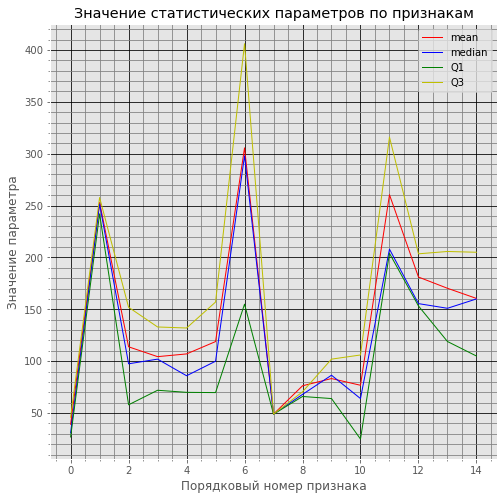

Значительное различие между медианой и средним в колонке "Bulk 1"
Разница составляет 21%, возможны выбросы

Значительное различие между медианой и средним в колонке "Bulk 12"
Разница составляет 20%, возможны выбросы



In [245]:
_ = plot_stat_info(data_bulk, data_bulk.columns[1:], diff_treshhold=.2)

In [246]:
data_bulk.key.nunique()

3129

Вывод:

* Дубликатов не обнаружено;
* Пропусков основная часть. Необходимы уточнения параметра - либо это вид сыпучего материала, либо это подача из определенного источника
* Наблюдается сильно большое значение максимума для `Bulk 12` почти в 6 раз больше, чем 75-й процентиль
* Количество уникальных ключей - `key` больше чем для `data_arc`

Время подачи сыпучих материалов

In [247]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

In [248]:
main_info_description(data_bulk_time)

Количество дубликатов в датасете:
0

Типы данных в датасете:
object    15
int64      1
dtype: int64

Размерность датасета:
(3129, 16)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


In [249]:
null_values_fraction(data_bulk_time)

Доля пропусков:

Bulk 8     99.97%
Bulk 13    99.42%
Bulk 9     99.39%
Bulk 2     99.30%
Bulk 7     99.20%
Bulk 5     97.54%
Bulk 10    94.38%
Bulk 11    94.34%
Bulk 1     91.95%
Bulk 6     81.59%
Bulk 4     67.59%
Bulk 3     58.52%
Bulk 15    28.16%
Bulk 12    21.70%
Bulk 14    10.32%
key         0.00%
dtype: object


In [250]:
data_bulk_time.describe()

key
count 3,129.000
mean  1,624.384
std     933.338
min       1.000
25%     816.000
50%   1,622.000
75%   2,431.000
max   3,241.000

In [251]:
data_bulk_time.key.nunique()

3129

In [252]:
sum(data_bulk_time.key != data_bulk.key)

0

Вывод:

* Дубликатов не обнаружено;
* Пропусков основная часть. Необходимы уточнения параметра - либо это вид сыпучего материала, либо это подача из определенного источника
* Данные времени имеют тип `object` нужно будет заменить на `datetime`
* Количество уникальных ключей - `key` больше чем для `data_arc` и совпадают с `data_bulk`

Продувка сплава газом

In [253]:
data_gas.head()

key  Газ 1
0    1 29.750
1    2 12.556
2    3 28.555
3    4 18.841
4    5  5.414

In [254]:
main_info_description(data_gas)

Количество дубликатов в датасете:
0

Типы данных в датасете:
int64      1
float64    1
dtype: int64

Размерность датасета:
(3239, 2)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


In [255]:
null_values_fraction(data_gas)

Доля пропусков:

Газ 1    0.00%
key      0.00%
dtype: object


In [256]:
data_gas.describe()

key     Газ 1
count 3,239.000 3,239.000
mean  1,621.861    11.002
std     935.386     6.220
min       1.000     0.008
25%     812.500     7.043
50%   1,622.000     9.836
75%   2,431.500    13.770
max   3,241.000    77.995

In [257]:
data_gas.key.nunique()

3239

Вывод:

* Дубликатов и пропусков не обнаружено;
* Количество уникальных ключей - `key` больше чем в предыдущих таблицах
* Максимальное по газу почти в 6 раз больше 75-го процентиля, возможно выброс

Измерение температуры

In [258]:
data_temp.head()

key         Время замера  Температура
0    1  2019-05-03 11:16:18    1,571.000
1    1  2019-05-03 11:25:53    1,604.000
2    1  2019-05-03 11:29:11    1,618.000
3    1  2019-05-03 11:30:01    1,601.000
4    1  2019-05-03 11:30:39    1,613.000

In [259]:
main_info_description(data_temp)

Количество дубликатов в датасете:
0

Типы данных в датасете:
int64      1
object     1
float64    1
dtype: int64

Размерность датасета:
(15907, 3)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


In [260]:
null_values_fraction(data_temp)

Доля пропусков:

Температура     18.24%
Время замера     0.00%
key              0.00%
dtype: object


In [261]:
data_temp.describe()

key  Температура
count 15,907.000   13,006.000
mean   1,607.881    1,591.841
std      942.212       21.376
min        1.000    1,191.000
25%      790.000    1,581.000
50%    1,618.000    1,591.000
75%    2,427.000    1,601.000
max    3,241.000    1,705.000

In [262]:
data_temp.key.nunique()

3216

Вывод:

* Дубликатов не обнаружено;
* Пропусков обнаружено 18,24% - возможно будет возможность восстановить, проверим далее
* Данные времени имеют тип `object` нужно будет заменить на `datetime`

Проволочные материалы(объем)

In [263]:
data_wire.head()

key  Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9
0    1  60.060     nan     nan     nan     nan     nan     nan     nan     nan
1    2  96.052     nan     nan     nan     nan     nan     nan     nan     nan
2    3  91.160     nan     nan     nan     nan     nan     nan     nan     nan
3    4  89.064     nan     nan     nan     nan     nan     nan     nan     nan
4    5  89.238   9.115     nan     nan     nan     nan     nan     nan     nan

In [264]:
main_info_description(data_wire)

Количество дубликатов в датасете:
0

Типы данных в датасете:
float64    9
int64      1
dtype: int64

Размерность датасета:
(3081, 10)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


In [265]:
null_values_fraction(data_wire)

Доля пропусков:

Wire 5    99.97%
Wire 7    99.64%
Wire 4    99.55%
Wire 8    99.38%
Wire 9    99.06%
Wire 3    97.96%
Wire 6    97.63%
Wire 2    64.98%
Wire 1     0.84%
key        0.00%
dtype: object


In [266]:
data_wire.describe()

key    Wire 1    Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
count 3,081.000 3,055.000 1,079.000  63.000  14.000   1.000  73.000  11.000   
mean  1,623.426   100.896    50.577 189.483  57.443  15.132  48.017  10.039   
std     932.997    42.013    39.320  99.513  28.825     nan  33.920   8.611   
min       1.000     1.919     0.030   0.144  24.149  15.132   0.034   0.234   
25%     823.000    72.116    20.194  95.135  40.807  15.132  25.054   6.763   
50%   1,619.000   100.158    40.143 235.195  45.234  15.132  42.076   9.017   
75%   2,434.000   126.060    70.228 276.252  76.125  15.132  64.213  11.886   
max   3,241.000   330.314   282.780 385.009 113.231  15.132 180.455  32.848   

       Wire 8  Wire 9  
count  19.000  29.000  
mean   53.625  34.156  
std    16.882  19.932  
min    45.077   4.623  
25%    46.095  22.058  
50%    46.280  30.066  
75%    48.090  43.862  
max   102.762  90.054

In [267]:
data_wire.key.nunique()

3081

Вывод:

* Дубликатов не обнаружено;
* Пропусков основная часть. Необходимо уточнения параметра
* Данные времени имеют тип `object` нужно будет заменить на `datetime`

Проволочные материалы(время)

In [268]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

In [269]:
main_info_description(data_wire_time)

Количество дубликатов в датасете:
0

Типы данных в датасете:
object    9
int64     1
dtype: int64

Размерность датасета:
(3081, 10)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


In [270]:
null_values_fraction(data_wire_time)

Доля пропусков:

Wire 5    99.97%
Wire 7    99.64%
Wire 4    99.55%
Wire 8    99.38%
Wire 9    99.06%
Wire 3    97.96%
Wire 6    97.63%
Wire 2    64.98%
Wire 1     0.84%
key        0.00%
dtype: object


In [271]:
data_wire_time.describe()

key
count 3,081.000
mean  1,623.426
std     932.997
min       1.000
25%     823.000
50%   1,619.000
75%   2,434.000
max   3,241.000

In [272]:
sum(data_wire.key != data_wire_time.key)

0

Вывод:

* Дубликатов не обнаружено;
* Пропусков основная часть. Необходимо уточнения параметра
* Данные времени имеют тип `object` нужно будет заменить на `datetime`

## Общий вывод:<a id='section1.2.1'></a>

1. Таблица с информацией о электродах:
    * Пропусков и дубликатов не обнаружено;
    * Данные времени имеют тип `object` нужно будет заменить на `datetime`
    * Наблюдается отрицательное значение реактивной мощности - возможно ошибка при записи


2. Таблица с информацией о количестве сыпучих материалов:
    * Дубликатов не обнаружено;
    * Пропусков основная часть. Необходимы уточнения параметра - либо это вид сыпучего материала, либо это подача из определенного источника
    * Наблюдается сильно большое значение максимума для `Bulk 12` почти в 6 раз больше, чем 75-й процентиль
    * Количество уникальных ключей - `key` больше чем для `data_arc`


3. Таблица с информацией о времени использования сыпучих материалов:
    * Дубликатов не обнаружено;
    * Пропусков основная часть. Необходимы уточнения параметра - либо это вид сыпучего материала, либо это подача из определенного источника
    * Данные времени имеют тип `object` нужно будет заменить на `datetime`
    * Количество уникальных ключей - `key` больше чем для `data_arc` и совпадают с `data_bulk`


4. Таблица о продувке сплава газом:
    * Дубликатов и пропусков не обнаружено;
    * Количество уникальных ключей - `key` больше чем в предыдущих таблицах
    * Максимальное по газу почти в 6 раз больше 75-го процентиля, возможно выброс
    
    
5. Таблица о измерении температуры:
    * Дубликатов не обнаружено;
    * Пропусков обнаружено 18,24% - возможно будет возможность восстановить, проверим далее
    * Данные времени имеют тип `object` нужно будет заменить на `datetime`


6. Таблицы о использовании количества проволоки и времени использования:
    * Дубликатов не обнаружено;
    * Пропусков основная часть. Необходимо уточнения параметра
    * Данные времени имеют тип `object` нужно будет заменить на `datetime`

[к Содержанию](#section0)

# 2. Предподготовка данных<a id='section2.0'></a>

## 2.1. Изменим тип данных<a id='section2.1'></a>

In [273]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [274]:
data_arc.dtypes

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object

In [275]:
for col in data_bulk_time.columns[1:]:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

In [276]:
data_bulk_time.dtypes

key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime64[ns]
Bulk 15    datetime64[ns]
dtype: object

In [277]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [278]:
data_temp.dtypes

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object

In [279]:
for col in data_wire_time.columns[1:]:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

In [280]:
data_wire_time.dtypes

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object

Заполнение пропусков после уточнения происхожнения величин Bulk и Ware

[к Содержанию](#section0)

# 3. Анализ табличных данных<a id='section3.0'></a>

## 3.1. Исследовательский анализ<a id='section3.1'></a>

### 3.1.1 Таблица с информацией о электродах <a id='section3.1.1'></a>

##### Найдем продолжительность каждой итерации в партии и потребленную энергию

In [281]:
def heating_duration(row):
    duration = row['Конец нагрева дугой'] - row['Начало нагрева дугой']
    return duration.seconds

In [282]:
data_arc['heating_duration_sec'] = data_arc.apply(heating_duration, axis=1)

##### Построим графики распределения

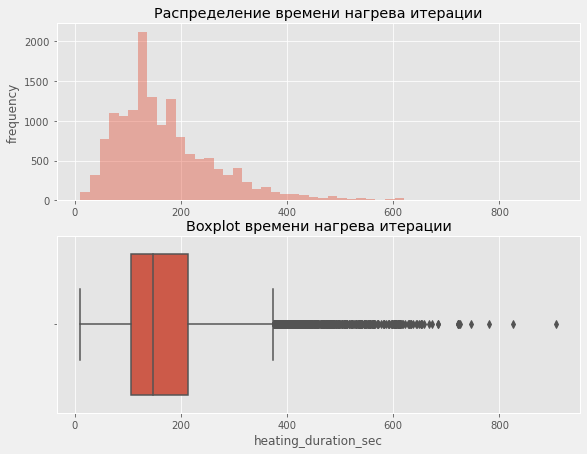

In [283]:
hist_box(data_arc.heating_duration_sec, 'времени нагрева итерации')

Наблюдаются выбросы, распределение умерено скошено в право

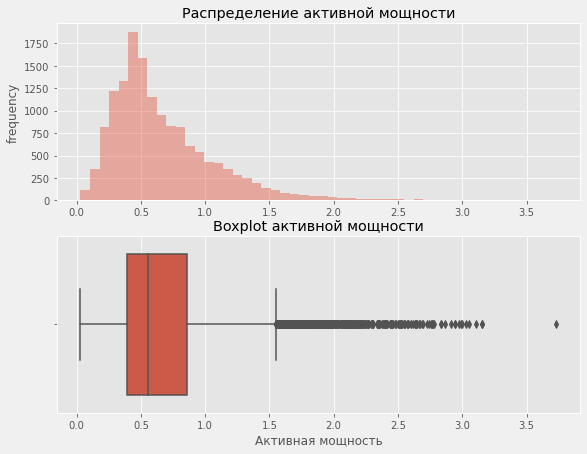

In [284]:
hist_box(data_arc['Активная мощность'], 'активной мощности')

Распределение логнорльного вида, прологарифмируем значения

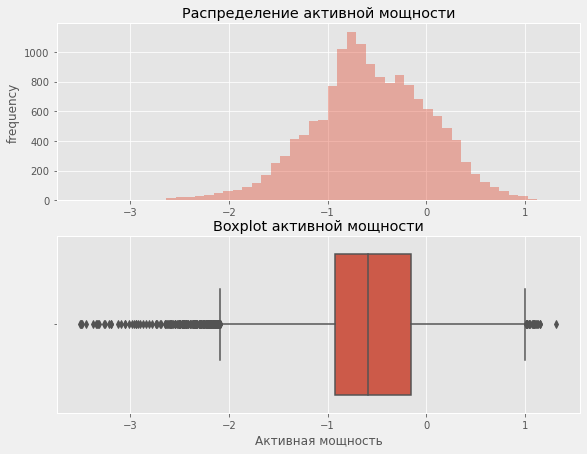

In [285]:
hist_box(np.log(data_arc['Активная мощность']), 'активной мощности')

После логарифмирования можно заметить, что распределение близкое к нормальному однако наблюдается некоторый пик в районе -0.2

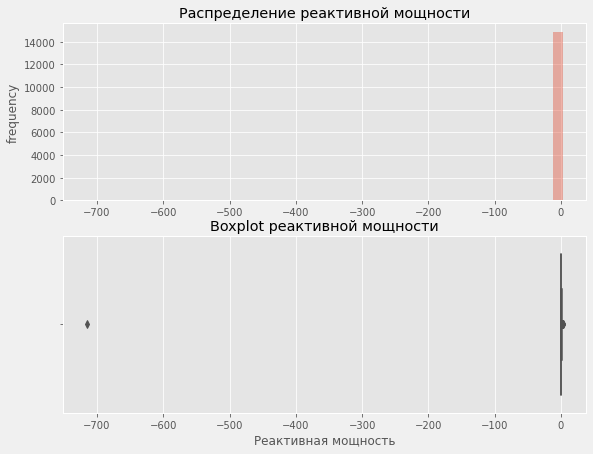

In [286]:
hist_box(data_arc['Реактивная мощность'], 'реактивной мощности')

Наличие отрицательных значений сильно сказывается на распределении, тем более отрицательных значений быть для потребителя мощности быть не может.
Т.к. в среднем соотношение Активной и Реактивной мощности примерно постоянные, то заменим отрицательное значение на значение доли от активной мощности

Найдем долю реактивной мощности

In [287]:
data_arc['reactive_power_fraction'] = (
    data_arc['Реактивная мощность'] /
    (data_arc['Активная мощность'] + data_arc['Реактивная мощность'])
)

In [288]:
query_negative_power_key = int(data_arc.loc[data_arc['Реактивная мощность'] < 0].key)
data_arc.query('key == @query_negative_power_key')

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-24 00:29:52 2019-07-24 00:31:54              0.433   
9779  2116  2019-07-24 00:35:50 2019-07-24 00:38:05              0.620   
9780  2116  2019-07-24 00:44:48 2019-07-24 00:46:37              0.496   
9781  2116  2019-07-24 00:51:51 2019-07-24 00:52:58              0.299   

      Реактивная мощность  heating_duration_sec  reactive_power_fraction  
9778                0.306                   122                    0.414  
9779                0.408                   135                    0.397  
9780             -715.505                   109                    1.001  
9781                0.199                    67                    0.399

In [289]:
_qurey1 = data_arc['Реактивная мощность'] < 0, ['Реактивная мощность', 'reactive_power_fraction']
_query2 = data_arc['Реактивная мощность'] < 0, 'Активная мощность'
_query3 = data_arc.key == query_negative_power_key, 'reactive_power_fraction'
_query4 = (data_arc.key == query_negative_power_key) & (data_arc['Реактивная мощность'] > 0), 'reactive_power_fraction'

data_arc.loc[_qurey1] =(
    [
        (data_arc.loc[_query2] * data_arc.loc[_query4].mean()) / (1 - data_arc.loc[_query4].mean()),
        data_arc.loc[_query4].mean()
    ]
)

In [290]:
data_arc.query('key == @query_negative_power_key')

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-24 00:29:52 2019-07-24 00:31:54              0.433   
9779  2116  2019-07-24 00:35:50 2019-07-24 00:38:05              0.620   
9780  2116  2019-07-24 00:44:48 2019-07-24 00:46:37              0.496   
9781  2116  2019-07-24 00:51:51 2019-07-24 00:52:58              0.299   

      Реактивная мощность  heating_duration_sec  reactive_power_fraction  
9778                0.306                   122                    0.414  
9779                0.408                   135                    0.397  
9780                0.335                   109                    0.403  
9781                0.199                    67                    0.399

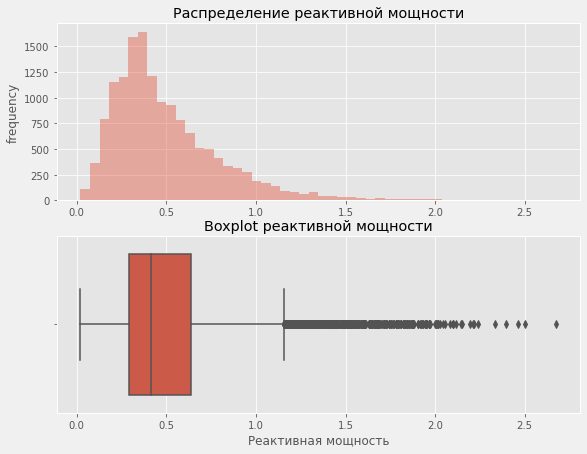

In [291]:
hist_box(data_arc['Реактивная мощность'], 'реактивной мощности')

Прологарифмируем

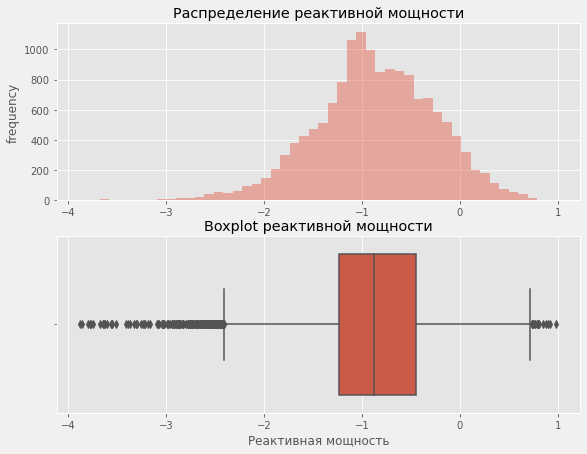

In [292]:
hist_box(np.log(data_arc['Реактивная мощность']), 'реактивной мощности')

Наблюдается логнормальное распределение, с неярко выраженными пиками в районе -0,4 и -1.
Значения за границей левого и правого "уса" требуют проверки, соответствует ли это нормальной работе оборудования.
При этом активная и реактивная мощности должны быть взаимозависимы - никая активная мощность - высокая реактивная и наоборот

Определим значения границ 

In [293]:
def outliers_boundary(series, coeff=OUTLIERS_COEFF):
    
    q1  = series.quantile(.25)
    q3  = series.quantile(.75)
    
    iqr = q3 - q1
    
    low_bound   = q1 - iqr * coeff
    upper_bound = q3 + iqr * coeff
    
    return low_bound, upper_bound

In [294]:
reactive_power_outliers_bounds = outliers_boundary(np.log(data_arc['Реактивная мощность']))

In [295]:
data_arc[np.log(data_arc['Реактивная мощность']) < reactive_power_outliers_bounds[0]].describe()

key  Активная мощность  Реактивная мощность  heating_duration_sec  \
count   210.000            210.000              210.000               210.000   
mean  1,716.452              0.095                0.067                28.319   
std     919.092              0.028                0.019                11.798   
min      44.000              0.030                0.021                11.000   
25%     937.000              0.081                0.056                23.000   
50%   1,689.000              0.098                0.072                29.000   
75%   2,567.000              0.118                0.083                33.000   
max   3,223.000              0.147                0.090               156.000   

       reactive_power_fraction  
count                  210.000  
mean                     0.413  
std                      0.031  
min                      0.351  
25%                      0.392  
50%                      0.408  
75%                      0.428  
max                      0.572

Наблюдаются короткие итерации нагрева, возможно были проблемы в работе оборудования - похоже, что оборудование не давало необходимую мощность

In [296]:
data_arc[np.log(data_arc['Реактивная мощность']) > reactive_power_outliers_bounds[1]].describe()

key  Активная мощность  Реактивная мощность  heating_duration_sec  \
count    16.000             16.000               16.000                16.000   
mean  1,858.562              2.732                2.252               672.688   
std     861.472              0.605                0.175               111.826   
min     552.000              0.979                2.082               443.000   
25%   1,426.750              2.639                2.114               611.750   
50%   2,015.000              2.822                2.205               676.000   
75%   2,430.250              3.013                2.351               721.750   
max   3,086.000              3.732                2.676               907.000   

       reactive_power_fraction  
count                   16.000  
mean                     0.459  
std                      0.068  
min                      0.412  
25%                      0.427  
50%                      0.437  
75%                      0.451  
max                      0.682

Продолжительные и мощные нагревы

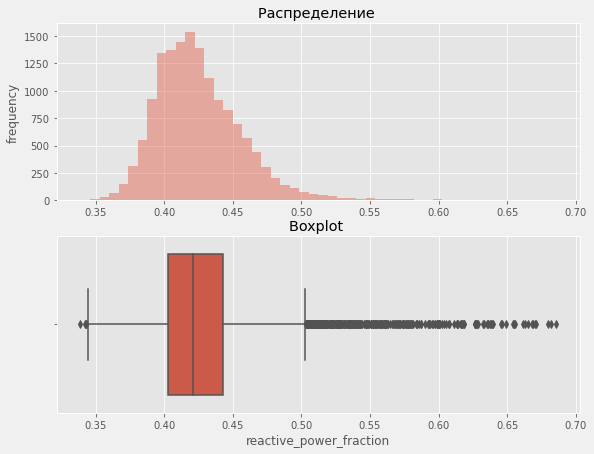

In [297]:
hist_box(data_arc.reactive_power_fraction)

В качестве задания для работы было указано, что необходимо оптимизировать энергопотребление, предсказывая температуру стали, таким образом расчитаем количество потребленной энергии с учетом продолжительности использования электрической мощности для нагрева электродов

In [298]:
data_arc['active_energ_consume']    = data_arc['Активная мощность']  * data_arc['heating_duration_sec'] / SEC_IN_HOUR
data_arc['reactive_energ_consume']  = data_arc['Реактивная мощность'] * data_arc['heating_duration_sec'] / SEC_IN_HOUR
data_arc['energy_consumption']      = np.sqrt(data_arc['active_energ_consume']**2
                                              + data_arc['reactive_energ_consume']**2)

In [299]:
data_arc.describe()

key  Активная мощность  Реактивная мощность  \
count 14,876.000         14,876.000           14,876.000   
mean   1,615.220              0.670                0.501   
std      934.572              0.408                0.311   
min        1.000              0.030                0.021   
25%      806.000              0.395                0.291   
50%    1,617.000              0.556                0.416   
75%    2,429.000              0.857                0.637   
max    3,241.000              3.732                2.676   

       heating_duration_sec  reactive_power_fraction  active_energ_consume  \
count            14,876.000               14,876.000            14,876.000   
mean                171.671                    0.426                 0.043   
std                  98.187                    0.034                 0.057   
min                  11.000                    0.339                 0.000   
25%                 107.000                    0.403                 0.012   
50%                 147.000                    0.421                 0.022   
75%                 214.000                    0.443                 0.051   
max                 907.000                    0.686                 0.940   

       reactive_energ_consume  energy_consumption  
count              14,876.000          14,876.000  
mean                    0.032               0.054  
std                     0.043               0.072  
min                     0.000               0.000  
25%                     0.009               0.015  
50%                     0.017               0.028  
75%                     0.038               0.063  
max                     0.674               1.157

##### Найдем продолжительность подготовки, время нагрева и потребленную энергию для каждой партии

In [300]:
arc_agg_dict = {
    'Начало нагрева дугой' : 'min',
    'Конец нагрева дугой' : 'max',
    'heating_duration_sec' : 'sum',
    'active_energ_consume' : 'sum',
    'reactive_energ_consume' : 'sum',
    'energy_consumption' : 'sum',
    'reactive_power_fraction' : 'mean',
}
data_arc_grouped = data_arc.groupby(by='key').agg(arc_agg_dict)

In [301]:
data_arc_grouped['total_duration'] = data_arc_grouped.apply(heating_duration, axis=1)

In [302]:
data_arc_grouped['time_diff'] = data_arc_grouped['total_duration'] - data_arc_grouped['heating_duration_sec']

In [303]:
data_arc_grouped.describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count             3,214.000             3,214.000               3,214.000   
mean                794.579                 0.198                   0.149   
std                 332.449                 0.143                   0.107   
min                  57.000                 0.003                   0.003   
25%                 571.000                 0.099                   0.074   
50%                 770.000                 0.168                   0.126   
75%                 983.000                 0.258                   0.193   
max               4,189.000                 2.396                   1.725   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count           3,214.000                3,214.000       3,214.000  3,214.000  
mean                0.248                    0.427       1,898.538  1,103.959  
std                 0.179                    0.026       1,265.105  1,088.408  
min                 0.004                    0.361          57.000      0.000  
25%                 0.124                    0.411       1,260.250    528.000  
50%                 0.212                    0.423       1,661.000    854.500  
75%                 0.323                    0.437       2,285.750  1,425.750  
max                 2.953                    0.603      23,485.000 19,296.000

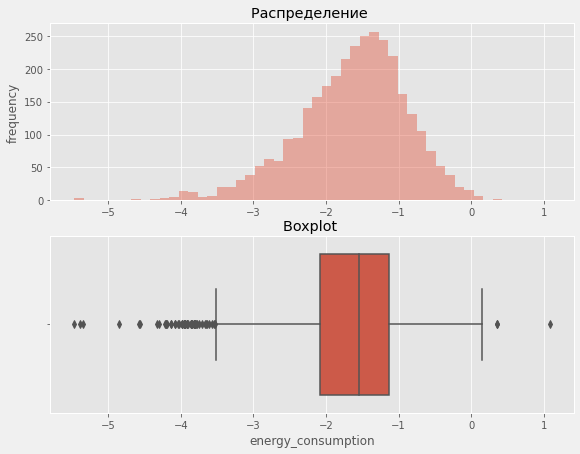

In [304]:
hist_box(np.log(data_arc_grouped.energy_consumption))

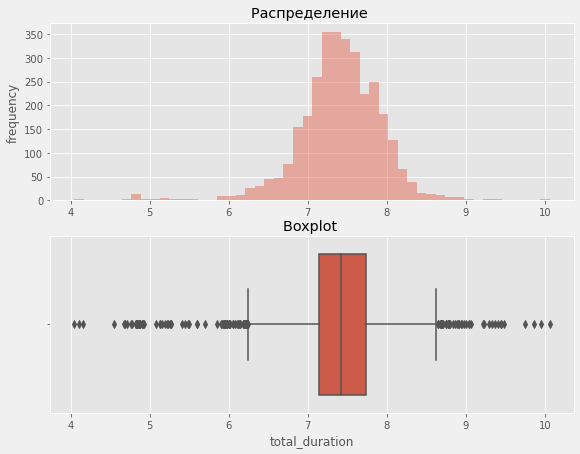

In [305]:
hist_box(np.log(data_arc_grouped.total_duration))

In [306]:
total_duration_log_outliers_bound = outliers_boundary(np.log(data_arc_grouped.total_duration))

In [307]:
total_duration_log_outliers_bound[0]

6.245989146228717

In [308]:
data_arc_grouped[np.log(data_arc_grouped.total_duration) < total_duration_log_outliers_bound[0]].describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count                84.000                84.000                  84.000   
mean                212.917                 0.034                   0.026   
std                  85.065                 0.023                   0.018   
min                  57.000                 0.003                   0.003   
25%                 131.250                 0.016                   0.012   
50%                 195.000                 0.031                   0.024   
75%                 275.500                 0.046                   0.037   
max                 414.000                 0.147                   0.098   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count              84.000                   84.000          84.000     84.000  
mean                0.043                    0.437         294.750     81.833  
std                 0.029                    0.026         154.835     88.990  
min                 0.004                    0.390          57.000      0.000  
25%                 0.021                    0.419         132.000      0.000  
50%                 0.039                    0.433         284.500     67.500  
75%                 0.057                    0.447         440.000    159.750  
max                 0.177                    0.505         515.000    335.000

In [309]:
data_arc_grouped[np.log(data_arc_grouped.total_duration) > total_duration_log_outliers_bound[1]].describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count                42.000                42.000                  42.000   
mean              1,618.524                 0.495                   0.378   
std                 716.931                 0.405                   0.301   
min                 547.000                 0.066                   0.045   
25%               1,199.500                 0.256                   0.193   
50%               1,431.000                 0.484                   0.360   
75%               1,947.500                 0.618                   0.463   
max               4,189.000                 2.396                   1.725   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count              42.000                   42.000          42.000     42.000  
mean                0.625                    0.435       9,112.143  7,493.619  
std                 0.503                    0.026       4,302.086  3,895.046  
min                 0.080                    0.398       5,676.000  3,903.000  
25%                 0.327                    0.415       6,310.000  4,933.000  
50%                 0.604                    0.428       7,403.500  6,042.000  
75%                 0.781                    0.452      10,718.500  8,832.000  
max                 2.953                    0.490      23,485.000 19,296.000

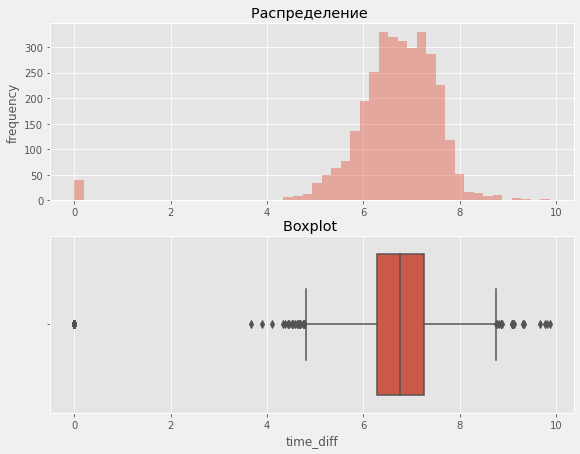

In [310]:
hist_box(np.log(data_arc_grouped.time_diff+1))

In [311]:
data_arc_grouped[np.log(data_arc_grouped.time_diff+1) < 4].describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count                41.000                41.000                  41.000   
mean                151.829                 0.026                   0.020   
std                  62.470                 0.025                   0.018   
min                  57.000                 0.003                   0.003   
25%                 124.000                 0.015                   0.011   
50%                 132.000                 0.017                   0.013   
75%                 180.000                 0.031                   0.024   
max                 414.000                 0.147                   0.098   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count              41.000                   41.000          41.000     41.000  
mean                0.033                    0.436         153.927      2.098  
std                 0.030                    0.026          68.777      9.444  
min                 0.004                    0.390          57.000      0.000  
25%                 0.018                    0.418         124.000      0.000  
50%                 0.021                    0.432         132.000      0.000  
75%                 0.040                    0.445         180.000      0.000  
max                 0.177                    0.505         452.000     48.000

[к Содержанию](#section0)

### 3.1.2 Таблицы с информацией о сыпучих материалах <a id='section3.1.2'></a>

In [312]:
data_bulk['total_bulk'] = data_bulk[data_bulk.columns[1:]].sum(axis=1)

In [313]:
data_bulk['total_bulk'].describe()

count   3,129.000
mean      595.503
std       276.558
min        19.000
25%       429.000
50%       591.000
75%       772.000
max     3,235.000
Name: total_bulk, dtype: float64

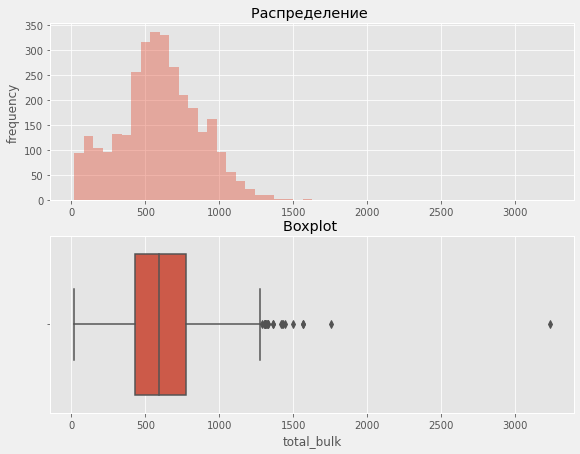

In [314]:
hist_box(data_bulk['total_bulk'])

Найдем номера партий при которых общее количество сыпучих материалов `total_bulk` на гразицей нормальных значений и посмотрим какой режим по затраченой энергии и продолжительности был в таблице `data_arc_grouped`

In [315]:
total_bulk_outliers_bounds = outliers_boundary(data_bulk['total_bulk'])

In [316]:
keys_with_total_bulk_outliers = data_bulk[data_bulk.total_bulk > total_bulk_outliers_bounds[1]].key
data_arc_grouped.loc[keys_with_total_bulk_outliers].describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count                21.000                21.000                  21.000   
mean              1,577.571                 0.560                   0.425   
std                 783.241                 0.470                   0.345   
min                 704.000                 0.126                   0.108   
25%               1,197.000                 0.398                   0.278   
50%               1,399.000                 0.449                   0.346   
75%               1,584.000                 0.603                   0.444   
max               4,189.000                 2.396                   1.725   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count              21.000                   21.000          21.000     21.000  
mean                0.704                    0.427       4,857.524  3,279.952  
std                 0.583                    0.022       5,181.329  4,504.955  
min                 0.166                    0.383       2,043.000    604.000  
25%                 0.506                    0.416       2,397.000  1,304.000  
50%                 0.581                    0.424       2,875.000  1,529.000  
75%                 0.749                    0.442       3,734.000  2,218.000  
max                 2.953                    0.476      23,485.000 19,296.000

Как видно всем партиям своственно "большое" время продолжительности нагрева 1-й квартиль в полученой выборке уже больше 3-го квартиля  в ~1,5 раза. Также существенное увеличение наблюдается для общей продолжительности подготовки партии и потребленной энергии (здесь 1-й квартиль из полученой выборки в почти 2 раза больше 3-го квартиля общей выборки) 

Если номер Bulk важен, то пропуски можно заменить на нули, тогда представление засыпки сыпучего материала будет ввиде вектора размерностью 16, где в качестве значений будет соответствовать количество использованного материала из соответствующего Bulk

Т.к. ненулевых значений нет, то заменим пропуски на нули

In [317]:
data_bulk = data_bulk.fillna(value=0)

In [318]:
null_values_fraction(data_bulk)

Доля пропусков:

total_bulk    0.00%
Bulk 7        0.00%
Bulk 1        0.00%
Bulk 2        0.00%
Bulk 3        0.00%
Bulk 4        0.00%
Bulk 5        0.00%
Bulk 6        0.00%
Bulk 8        0.00%
Bulk 15       0.00%
Bulk 9        0.00%
Bulk 10       0.00%
Bulk 11       0.00%
Bulk 12       0.00%
Bulk 13       0.00%
Bulk 14       0.00%
key           0.00%
dtype: object


[к Содержанию](#section0)

### 3.1.3 Таблица с информацией о температуре <a id='section3.1.3'></a>

In [319]:
data_temp.describe()

key  Температура
count 15,907.000   13,006.000
mean   1,607.881    1,591.841
std      942.212       21.376
min        1.000    1,191.000
25%      790.000    1,581.000
50%    1,618.000    1,591.000
75%    2,427.000    1,601.000
max    3,241.000    1,705.000

In [320]:
data_temp.columns = ['key', 'Время_замера', 'Температура']

In [321]:
last_time_temp_measurement = data_temp[['key', 'Время_замера']].groupby(by='key').last().Время_замера.values

In [322]:
last_time_temp_measurement

array(['2019-05-03T11:30:39.000000000', '2019-05-03T11:59:12.000000000',
       '2019-05-03T12:34:57.000000000', ...,
       '2019-09-01T02:24:15.000000000', '2019-09-01T03:35:16.000000000',
       '2019-09-01T04:38:08.000000000'], dtype='datetime64[ns]')

In [323]:
data_temp.query('Время_замера in @last_time_temp_measurement').isnull().sum()

key               0
Время_замера      0
Температура     739
dtype: int64

Удалим ключи с номерами партий в которых отсутствует значение последнего замера, т.к. это будет наш целевой признак и отсутствие последнего замера означает отсутствие таргета

In [324]:
data_temp_with_nulls_last_temp = data_temp.query('Время_замера in @last_time_temp_measurement')

In [325]:
keys_with_null_last_temp = data_temp_with_nulls_last_temp\
                .loc[data_temp_with_nulls_last_temp.Температура.isnull(), 'key'].values

In [326]:
data_temp = data_temp.query('key not in @keys_with_null_last_temp')

In [327]:
first_time_temp_measurement = data_temp[['key', 'Время_замера']].groupby(by='key').first().Время_замера.values

In [328]:
data_temp.query('Время_замера in @first_time_temp_measurement').isnull().sum()

key             0
Время_замера    0
Температура     0
dtype: int64

Первый замер всегда был

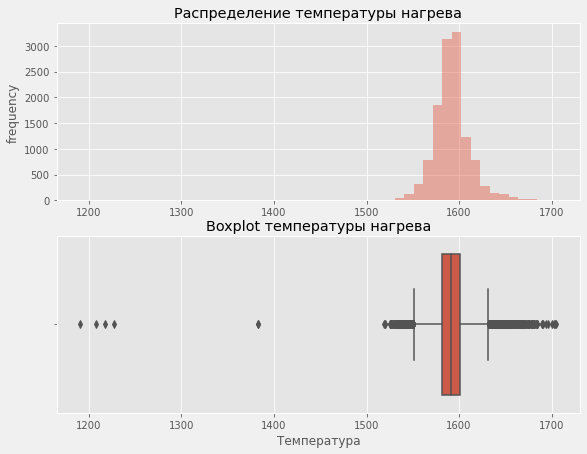

In [329]:
hist_box(data_temp['Температура'], 'температуры нагрева')

In [330]:
temp_outliers_bound = outliers_boundary(data_temp['Температура'])

In [331]:
key_with_low_temp = data_temp[data_temp['Температура'] < temp_outliers_bound[0]].key

Проверим для партий где низкая температура фиксировалатсь более 2-х раз

In [332]:
key_with_low_temp_freq = key_with_low_temp.value_counts()

In [333]:
keys_with_low_temp_more_3_times = key_with_low_temp_freq[key_with_low_temp_freq > 2].index.values

In [334]:
keys_with_low_temp_more_3_times

array([2108, 1622, 2107, 1948, 1504, 2106])

In [335]:
data_temp.query('key in @keys_with_low_temp_more_3_times').describe()

key  Температура
count    52.000       52.000
mean  1,989.442    1,572.365
std     211.140       30.396
min   1,504.000    1,530.000
25%   1,948.000    1,545.750
50%   2,106.500    1,558.500
75%   2,108.000    1,600.250
max   2,108.000    1,641.000

Температура умеренно низкая, аномально низких значений не неблюдается

In [336]:
data_temp.query('key == 1504')

key        Время_замера  Температура
7394  1504 2019-06-26 13:14:32    1,545.000
7395  1504 2019-06-26 13:25:46    1,545.000
7396  1504 2019-06-26 13:26:10    1,550.000
7397  1504 2019-06-26 13:32:55    1,568.000

In [337]:
data_arc.query('key == 1504')

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
6919  1504  2019-06-26 13:08:34 2019-06-26 13:11:06              0.485   
6920  1504  2019-06-26 13:17:15 2019-06-26 13:22:45              1.248   
6921  1504  2019-06-26 13:26:32 2019-06-26 13:31:44              1.297   

      Реактивная мощность  heating_duration_sec  reactive_power_fraction  \
6919                0.426                   152                    0.468   
6920                1.065                   330                    0.460   
6921                0.966                   312                    0.427   

      active_energ_consume  reactive_energ_consume  energy_consumption  
6919                 0.020                   0.018               0.027  
6920                 0.114                   0.098               0.150  
6921                 0.112                   0.084               0.140

In [338]:
data_bulk.query('key == 1504')

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
1450  1504   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   

      Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  total_bulk  
1450   0.000    0.000    0.000  206.000    0.000  102.000  204.000     512.000

In [339]:
data_bulk_time.query('key == 1504')

key Bulk 1 Bulk 2 Bulk 3 Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
1450  1504    NaT    NaT    NaT    NaT    NaT    NaT    NaT    NaT    NaT   

     Bulk 10 Bulk 11             Bulk 12 Bulk 13             Bulk 14  \
1450     NaT     NaT 2019-06-26 13:17:23     NaT 2019-06-26 13:17:23   

                 Bulk 15  
1450 2019-06-26 13:17:23

как видно, не для каждой итерации по нагреву предшествует замер температуры, иногда это производится в течение нагрева, иногда замер не производят после окончания нагрева

Поэтому предлагается выбрать начальное и конечное значение температуры для каждой партии, также выделим максимум и минимум

In [340]:
data_temp_grouped = data_temp.groupby(by='key').agg({'Температура' : ['first', 'last', 'max', 'min', 'std']})

In [341]:
null_values_fraction(data_temp_grouped)

Доля пропусков:

Температура  std      0.08%
             min      0.00%
             max      0.00%
             last     0.00%
             first    0.00%
dtype: object


In [342]:
_cols = []
for col in data_temp_grouped.columns:
    _cols.append(col[1] + '_temp')
data_temp_grouped.columns = _cols

In [343]:
data_temp_grouped.describe()

first_temp  last_temp  max_temp  min_temp  std_temp
count   2,477.000  2,477.000 2,477.000 2,477.000 2,475.000
mean    1,588.406  1,595.334 1,603.275 1,578.075    10.715
std        29.233     16.019    18.633    23.785     8.403
min     1,191.000  1,541.000 1,558.000 1,191.000     0.000
25%     1,572.000  1,587.000 1,591.000 1,568.000     6.083
50%     1,588.000  1,593.000 1,599.000 1,579.000     9.550
75%     1,605.000  1,599.000 1,613.000 1,589.000    13.704
max     1,679.000  1,700.000 1,705.000 1,661.000   174.268

In [344]:
data_temp_grouped[data_temp_grouped.std_temp == 0]#все температуры одинаковые в течение итераций

first_temp  last_temp  max_temp  min_temp  std_temp
key                                                      
632    1,579.000  1,579.000 1,579.000 1,579.000     0.000
2254   1,592.000  1,592.000 1,592.000 1,592.000     0.000
2312   1,591.000  1,591.000 1,591.000 1,591.000     0.000

In [345]:
keys_with_one_temp = data_temp_grouped.loc[data_temp_grouped.std_temp.isnull()].index.values 

In [346]:
data_temp_std_temp_null_grouped = data_temp.query('key in @keys_with_one_temp').groupby('key').count()

In [347]:
data_temp_std_temp_null_grouped['Температура'].unique() #Присутствует только 1-й замер - удаляем

array([1])

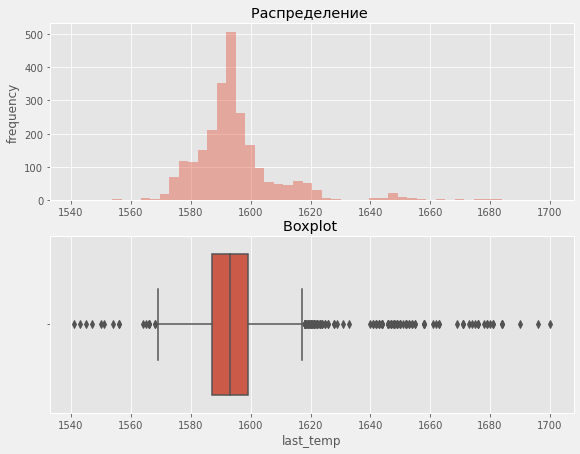

In [348]:
hist_box(data_temp_grouped.last_temp)

Распределение близкое к нормальному, наблюдаются выбросы, обрабатывать которые будем как и все остальные выбросы после уточнения информации о данных

[к Содержанию](#section0)

### 3.1.4 Таблица с информацией о газе <a id='section3.1.4'></a>

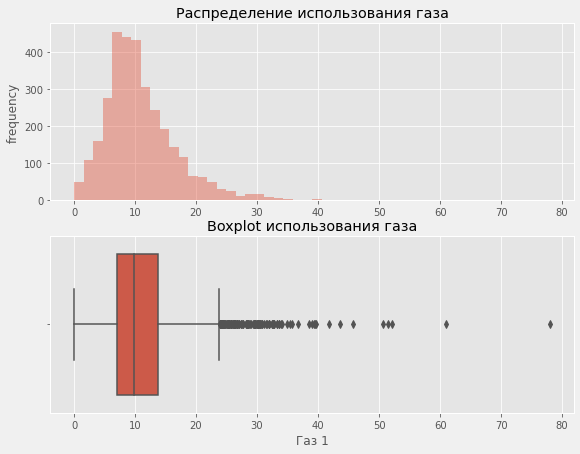

In [349]:
hist_box(data_gas['Газ 1'], 'использования газа')

Распределение близко к нормальному, однако имеет ассиметрию ввиде длинного "хвоста", возможно выбросы, проверим, каким данных из предыдущих таблиц соответствуют эти выбросы

In [350]:
gas_outliers_bound = outliers_boundary(data_gas['Газ 1'])

In [351]:
key_with_high_gas = data_gas[data_gas['Газ 1'] > gas_outliers_bound[1]].key

In [352]:
data_arc_grouped.query('index in @key_with_high_gas').describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count               126.000               126.000                 126.000   
mean              1,117.492                 0.303                   0.228   
std                 525.298                 0.261                   0.199   
min                 272.000                 0.036                   0.035   
25%                 817.500                 0.144                   0.106   
50%               1,015.000                 0.246                   0.176   
75%               1,257.500                 0.382                   0.280   
max               4,189.000                 2.396                   1.725   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count             126.000                  126.000         126.000    126.000  
mean                0.380                    0.423       3,740.738  2,623.246  
std                 0.328                    0.030       3,418.350  3,050.967  
min                 0.051                    0.370         650.000    179.000  
25%                 0.181                    0.404       2,110.250  1,176.750  
50%                 0.305                    0.418       2,830.500  1,794.500  
75%                 0.479                    0.438       3,712.000  2,666.250  
max                 2.953                    0.557      23,485.000 19,296.000

Единственные "аномалии" которые удалось установить соответствуют таблице с информацией о электродах - наблюдается более высокие значения по продолжительности нагрева, при этом увеличение затраченой энергии не налюдается, наоборот несколько ниже

[к Содержанию](#section0)

### 3.1.5 Таблица с информацией о проволочных материалах <a id='section3.1.5'></a>

In [353]:
null_values_fraction(data_wire)

Доля пропусков:

Wire 5    99.97%
Wire 7    99.64%
Wire 4    99.55%
Wire 8    99.38%
Wire 9    99.06%
Wire 3    97.96%
Wire 6    97.63%
Wire 2    64.98%
Wire 1     0.84%
key        0.00%
dtype: object


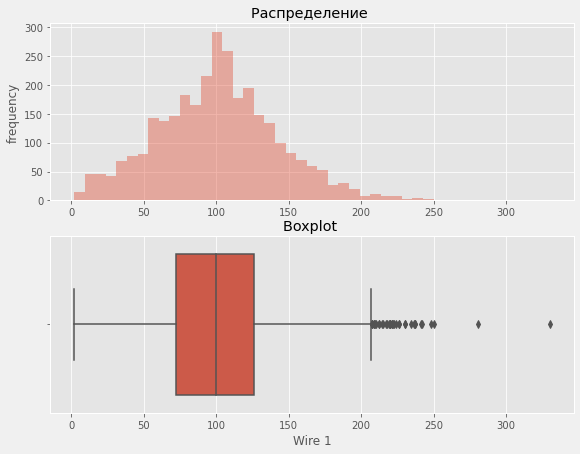

In [354]:
hist_box(data_wire['Wire 1'])

Распределение близкое к нормальному, имеет небольшой хвост в виде выбросов

In [355]:
wire1_otliers_bound = outliers_boundary(data_wire['Wire 1'])
key_with_high_wire1 = data_wire[data_wire['Wire 1'] > wire1_otliers_bound[1]].key
data_arc_grouped.query('index in @key_with_high_wire1').describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count                36.000                36.000                  36.000   
mean              1,052.750                 0.273                   0.198   
std                 313.286                 0.149                   0.109   
min                 626.000                 0.081                   0.056   
25%                 751.750                 0.171                   0.119   
50%               1,056.000                 0.237                   0.175   
75%               1,310.000                 0.337                   0.262   
max               1,925.000                 0.801                   0.553   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count              36.000                   36.000          36.000     36.000  
mean                0.337                    0.417       3,327.528  2,274.778  
std                 0.184                    0.024       2,537.632  2,420.336  
min                 0.099                    0.375       1,087.000    155.000  
25%                 0.206                    0.402       2,484.750  1,473.000  
50%                 0.291                    0.415       2,868.000  1,978.500  
75%                 0.412                    0.427       3,228.250  2,290.500  
max                 0.974                    0.504      17,134.000 15,721.000

Аналогичная картина с выбросами как и для газа - увеличенное время нагрева партии

In [356]:
data_temp_grouped.query('index in @key_with_high_wire1').describe()

first_temp  last_temp  max_temp  min_temp  std_temp
count      33.000     33.000    33.000    33.000    33.000
mean    1,605.788  1,606.303 1,620.091 1,586.606    12.337
std        24.424     15.314    16.949    16.869     5.267
min     1,564.000  1,580.000 1,592.000 1,538.000     2.881
25%     1,586.000  1,595.000 1,606.000 1,579.000     9.407
50%     1,606.000  1,607.000 1,618.000 1,586.000    11.349
75%     1,624.000  1,617.000 1,626.000 1,599.000    14.765
max     1,651.000  1,653.000 1,662.000 1,628.000    28.528

In [357]:
data_gas.query('key in @key_with_high_wire1').describe()

key  Газ 1
count    36.000 36.000
mean  1,408.639 16.322
std     676.461  9.288
min      33.000  1.018
25%   1,036.500 10.536
50%   1,433.000 13.775
75%   1,626.250 21.974
max   3,008.000 43.655

Также наблюдаются более высокий уровень температур при выбросах по `Wire 1` и повышеный расход газа

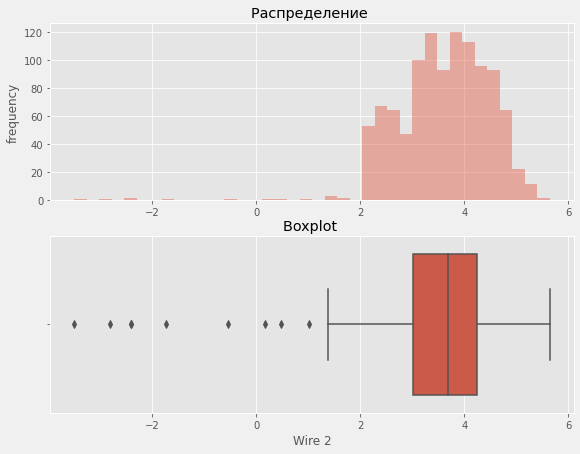

In [358]:
hist_box(np.log(data_wire['Wire 2']))

распределение после логарифмирования напоминает однородное, с двумя уровнями в районе 4 и 2,5

In [359]:
wire2_outliers_log_bound = outliers_boundary(np.log(data_wire['Wire 2']))
key_with_low_wire2 = data_wire[np.log(data_wire['Wire 2']) < wire2_outliers_log_bound[0]].key
data_arc_grouped.query('index in @key_with_low_wire2').describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count                 9.000                 9.000                   9.000   
mean                752.000                 0.200                   0.156   
std                 361.358                 0.219                   0.164   
min                 267.000                 0.037                   0.025   
25%                 520.000                 0.092                   0.067   
50%                 728.000                 0.122                   0.101   
75%                 776.000                 0.212                   0.175   
max               1,495.000                 0.757                   0.556   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count               9.000                    9.000           9.000      9.000  
mean                0.254                    0.430       1,882.000  1,130.000  
std                 0.273                    0.033         715.180    542.787  
min                 0.045                    0.397         383.000    116.000  
25%                 0.117                    0.408       1,505.000    850.000  
50%                 0.159                    0.419       2,067.000  1,125.000  
75%                 0.275                    0.433       2,240.000  1,512.000  
max                 0.940                    0.503       2,660.000  2,016.000

In [360]:
data_temp_grouped.query('index in @key_with_low_wire2').describe()

first_temp  last_temp  max_temp  min_temp  std_temp
count       8.000      8.000     8.000     8.000     8.000
mean    1,587.875  1,591.000 1,598.000 1,579.000     8.063
std        15.329     11.711     7.783    10.433     3.807
min     1,559.000  1,575.000 1,588.000 1,559.000     3.625
25%     1,582.500  1,585.250 1,592.250 1,574.250     5.197
50%     1,592.000  1,591.000 1,598.000 1,581.000     6.947
75%     1,598.250  1,596.250 1,602.000 1,586.250    11.752
max     1,605.000  1,611.000 1,611.000 1,591.000    13.491

In [361]:
data_gas.query('key in @key_with_low_wire2').describe()

key  Газ 1
count     9.000  9.000
mean    800.778 11.785
std     969.371  5.219
min     116.000  5.548
25%     311.000  7.243
50%     436.000  9.704
75%     769.000 16.993
max   3,193.000 18.355

При значения соответствующих выбросам по использованию `Wire 2` значимых отклонений по другим величинам не обнаружено

По аналогии с засыпными материалами заменим пропуски на нулевые значения и будем иметь представление о подаче проволоки ввиде векторного представления размерностью 9

In [362]:
data_wire.fillna(value=0, inplace=True)

In [363]:
data_wire['total_wire'] = data_wire[data_wire.columns[ 1 : ]].sum(axis=1)

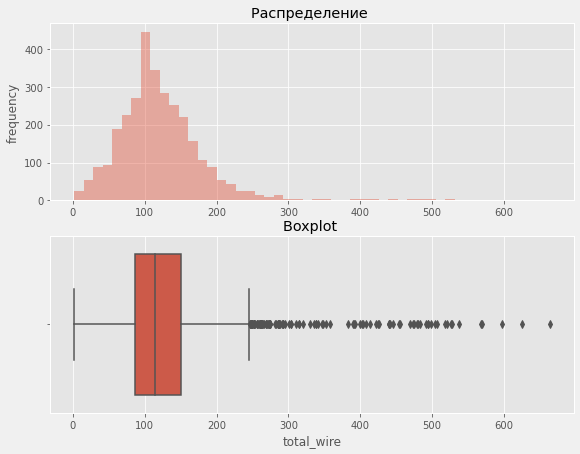

In [364]:
hist_box(data_wire.total_wire)

Распределение близкое к нормальному, имеет небольшой хвост в виде выбросов

In [365]:
total_wire_outliers_bound = outliers_boundary(data_wire.total_wire)
key_with_high_total_wire = data_wire[data_wire.total_wire > total_wire_outliers_bound[1]].key
data_arc_grouped.query('index in @key_with_high_total_wire').describe()

heating_duration_sec  active_energ_consume  reactive_energ_consume  \
count               107.000               107.000                 107.000   
mean                876.252                 0.205                   0.151   
std                 367.604                 0.136                   0.107   
min                  64.000                 0.004                   0.003   
25%                 644.500                 0.101                   0.074   
50%                 876.000                 0.187                   0.130   
75%               1,040.000                 0.262                   0.180   
max               2,739.000                 0.755                   0.782   

       energy_consumption  reactive_power_fraction  total_duration  time_diff  
count             107.000                  107.000         107.000    107.000  
mean                0.256                    0.423       2,642.449  1,766.196  
std                 0.172                    0.023       2,700.452  2,482.130  
min                 0.005                    0.370          64.000      0.000  
25%                 0.126                    0.407       1,650.500    753.000  
50%                 0.227                    0.422       2,195.000  1,290.000  
75%                 0.323                    0.435       2,784.000  1,905.500  
max                 1.091                    0.506      20,982.000 18,243.000

In [366]:
data_temp_grouped.query('index in @key_with_high_total_wire').describe()

first_temp  last_temp  max_temp  min_temp  std_temp
count      87.000     87.000    87.000    87.000    87.000
mean    1,588.506  1,589.402 1,602.713 1,571.678    12.618
std        28.873     15.296    18.163    19.329     7.189
min     1,519.000  1,541.000 1,578.000 1,519.000     0.000
25%     1,569.500  1,584.000 1,589.000 1,561.000     7.142
50%     1,587.000  1,589.000 1,598.000 1,573.000    12.226
75%     1,608.000  1,595.500 1,612.500 1,582.500    16.094
max     1,645.000  1,653.000 1,662.000 1,628.000    34.240

In [367]:
data_gas.query('key in @key_with_high_total_wire').describe()

key   Газ 1
count   107.000 107.000
mean  1,600.907  16.260
std     822.227   8.367
min      22.000   1.621
25%     959.500  11.243
50%   1,669.000  14.515
75%   2,372.500  18.797
max   3,092.000  60.936

При значениях опреленных как выбросы по общему использованию проволоки наблюдается повышенный расход газа

### Вывод<a id='section3.1.c'></a>

1) На данном шаге мы проанализировали данные, их распределение, определили границы выбросов, на основании которых произвели сравнение режимов работы, заполнили пропуски, выделили из имеющейся информации новые признаки.

2) На основании анализа выбросов и сравнительного анализа сформулировали вопросы на сколько уместно использовать эти данные для обучения модели.

## 3.2. Обработка Выбросов<a id='section3.2'></a>

Соеденим в единую выборку

In [368]:
data_bulk.set_index(keys='key', inplace=True)

In [369]:
data_gas.set_index(keys='key', inplace=True)

In [370]:
data_wire.set_index(keys='key', inplace=True)

In [371]:
data_temp_grouped.shape, data_arc_grouped.shape, data_bulk.shape, data_gas.shape, data_wire.shape

((2477, 5), (3214, 9), (3129, 16), (3239, 1), (3081, 10))

In [372]:
df = data_temp_grouped\
    .merge(data_arc_grouped[data_arc_grouped.columns[2:]], how='inner', left_index=True, right_index=True)\
    .merge(data_bulk, how='inner', left_index=True, right_index=True)\
    .merge(data_gas, how='inner', left_index=True, right_index=True)\
    .merge(data_wire, how='inner', left_index=True, right_index=True)

Удалим партии в которых был сделан только первый замер `std_temp == NaN` т.к. они не несут ни какой полезной информации для модели и для них first_temp и last_temp будет одним значением

In [373]:
df.columns = ['first_temp', 'last_temp', 'max_temp', 'min_temp', 'std_temp',
       'heating_duration_sec', 'active_energ_consume',
       'reactive_energ_consume', 'energy_consumption',
       'reactive_power_fraction', 'total_duration', 'time_diff', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'total_bulk', 'gas', 'wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'total_wire']

In [374]:
df.dropna(inplace=True)

In [375]:
df = df.loc[df.std_temp != 0]

In [376]:
input_features = [
    'first_temp', 'last_temp', 'max_temp', 'min_temp',
    'heating_duration_sec', 'energy_consumption', 'total_duration', 'total_bulk',
    'gas', 'total_wire', 'max_temp', 'min_temp'
    ]

Отображение пространства на проскость методом PCA


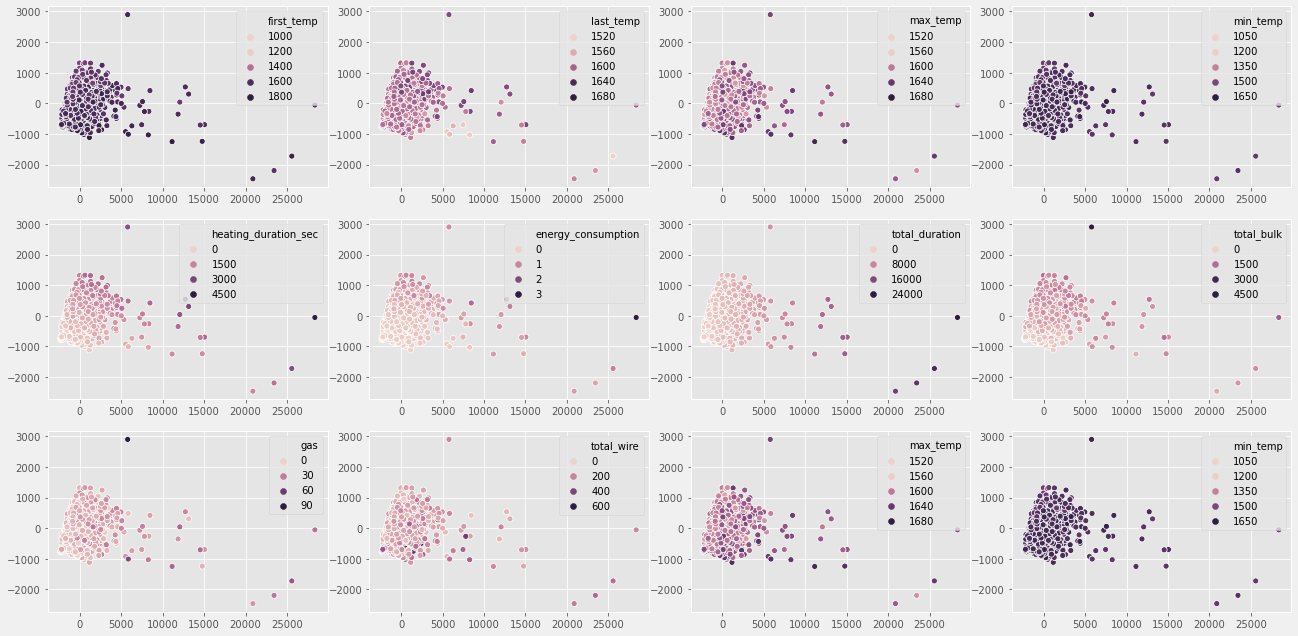

In [377]:
plot_PCA_projection(df, input_features)

Как видно основные выбросы(отдельно стоящие группы точек) соответствуют слишком высоким значениям продолжительности подготовки партии и использованию газа

Проверим, как выглядит проекция точек при помощи t_NSE

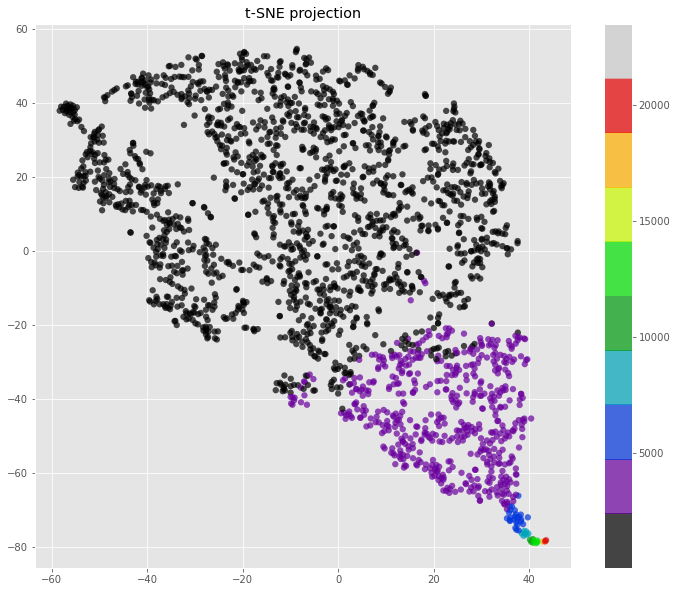

In [378]:
plot_TNSE_projection(df, 'total_duration')

Очевидно, что "аномальная" продолжительность подготовки партии находится в пространчтве очень обособлено

<small><small>Даже с учетом выполненной предподготовки мы уже получаем качество модели линейной регрессии с МАЕ = 5,94 однако продолжим производить очистку от выбросов для получения более качественной модели</small>

In [379]:
total_duration_outliers_bound = outliers_boundary(df.total_duration)

In [380]:
df = df.loc[df.total_duration <= total_duration_outliers_bound[1]]

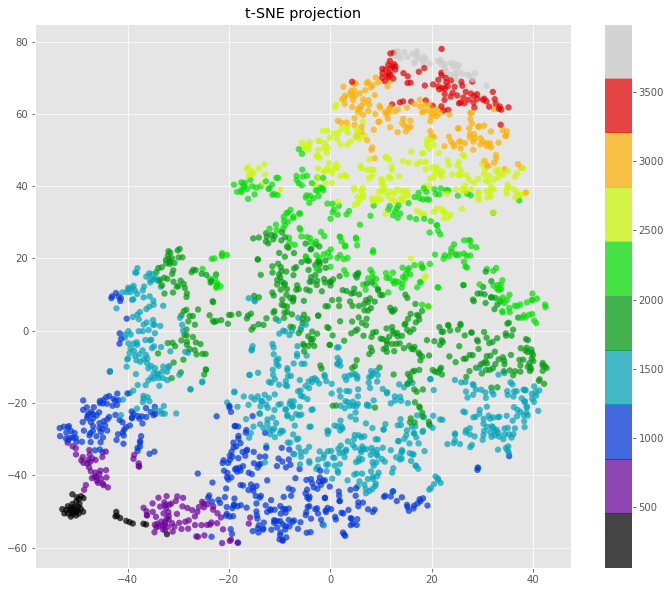

In [381]:
plot_TNSE_projection(df, 'total_duration')

Отображение пространства на проскость методом PCA


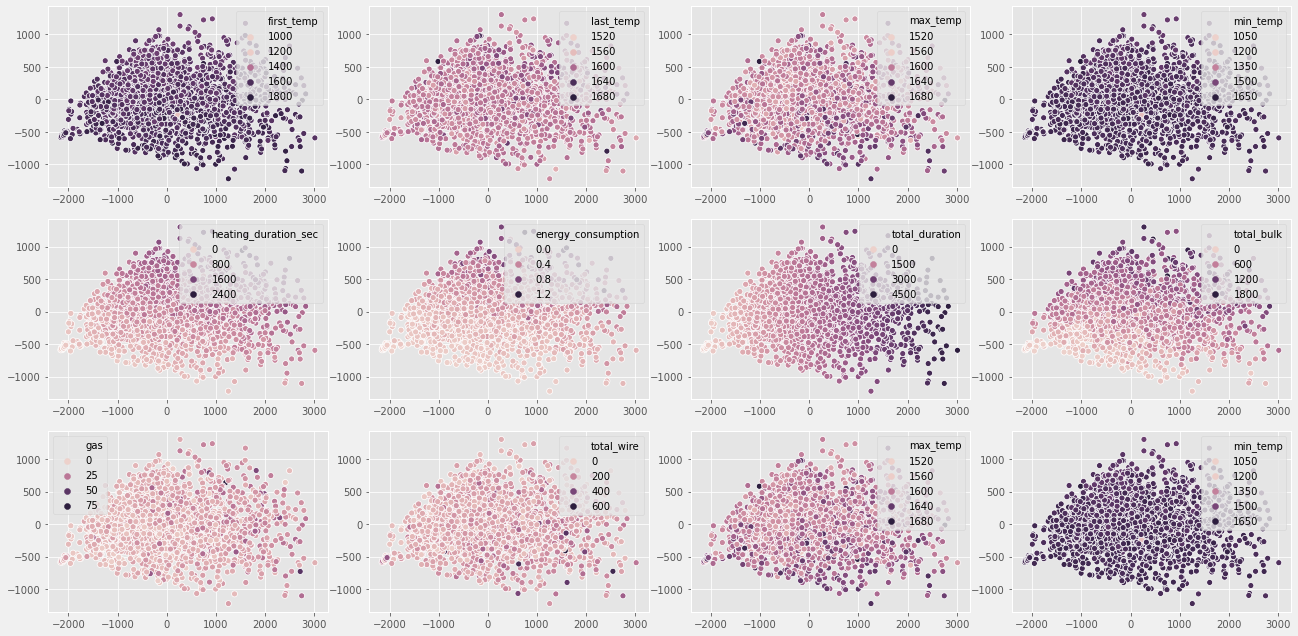

In [382]:
plot_PCA_projection(df, input_features)

Визуализация проекций принимает более логичную и плавную характеристику

In [383]:
gas_outliers_bound = outliers_boundary(df.gas, coeff=3.1)

Удалим выбросы которые превышают 99,5 персентиль (для данной выборки коэффициент для межквартильного размаха ~3,1)

In [384]:
df = df.loc[df.gas <= gas_outliers_bound[1]]

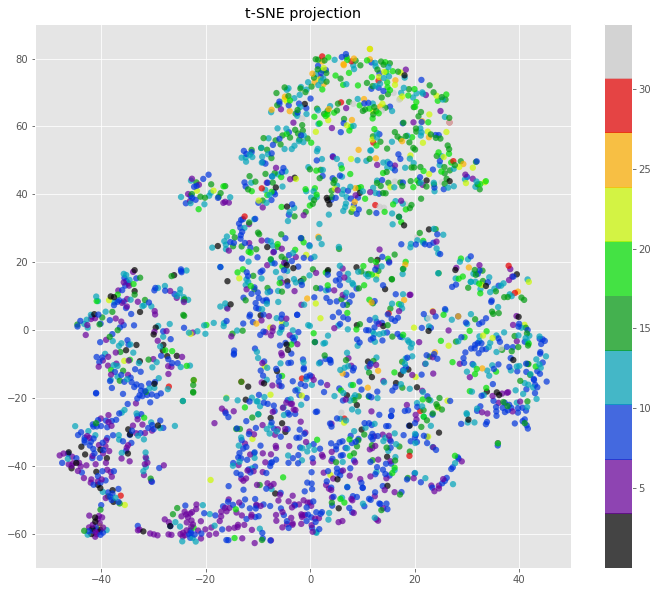

In [385]:
plot_TNSE_projection(df, 'gas')

Также наблюдались значительные выбросы для значения начальной температуры, удалим их

In [386]:
first_temp_outlies_bounds = outliers_boundary(df.first_temp)

In [387]:
df = df.loc[df.first_temp >= first_temp_outlies_bounds[0]]

In [388]:
df = df.loc[df.first_temp <= first_temp_outlies_bounds[1]]

Удалим аномальные значения финальной температуры

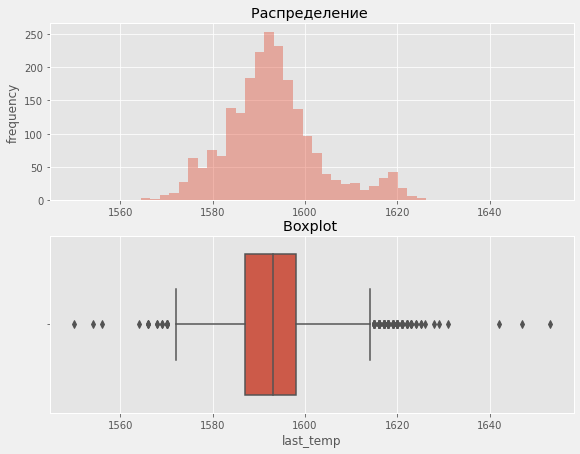

In [389]:
hist_box(df.last_temp)

In [390]:
last_temp_outliers_boundary = outliers_boundary(df.last_temp, coeff=3.5)

In [391]:
df = df.loc[df.last_temp >= last_temp_outliers_boundary[0]]
df = df.loc[df.last_temp <= last_temp_outliers_boundary[1]]

Удалим выбросы для аномально продолжительнего времени нагрева в парти

In [392]:
heating_duration_outlies_bounds = outliers_boundary(df.heating_duration_sec)

In [393]:
df = df.loc[df.heating_duration_sec <= heating_duration_outlies_bounds[1]]

Также удалим аномально короткие партии по нагреву

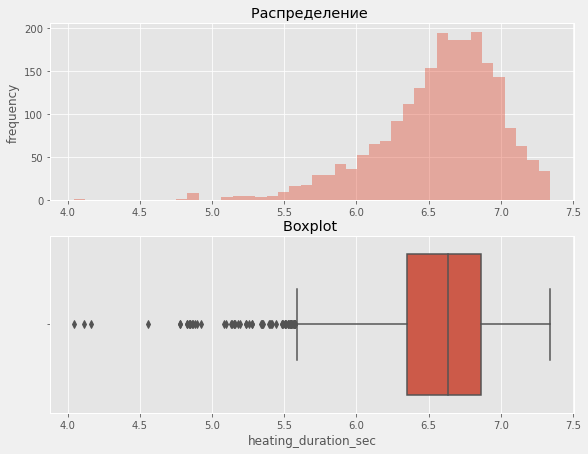

In [394]:
hist_box(np.log(df.heating_duration_sec))

In [395]:
heating_dur_log_outliers_boundary = outliers_boundary(np.log(df.heating_duration_sec), coeff=2.5)

In [396]:
df = df[np.log(df.heating_duration_sec) > heating_dur_log_outliers_boundary[0]]

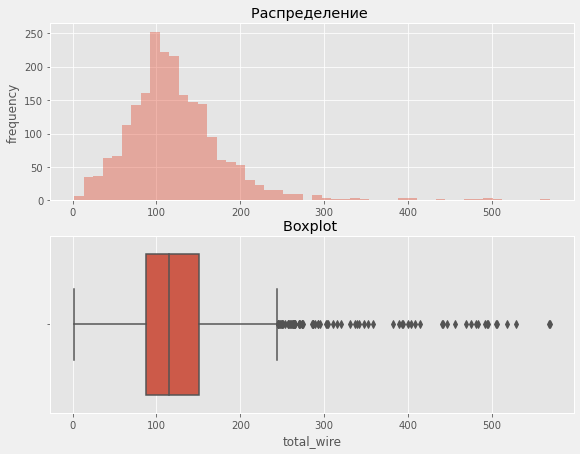

In [397]:
hist_box(df.total_wire)

In [398]:
total_wire_outliers_bound = outliers_boundary(df.total_wire, coeff=2.5)

In [399]:
df = df.loc[df.total_wire < total_wire_outliers_bound[1]]

Отображение пространства на проскость методом PCA


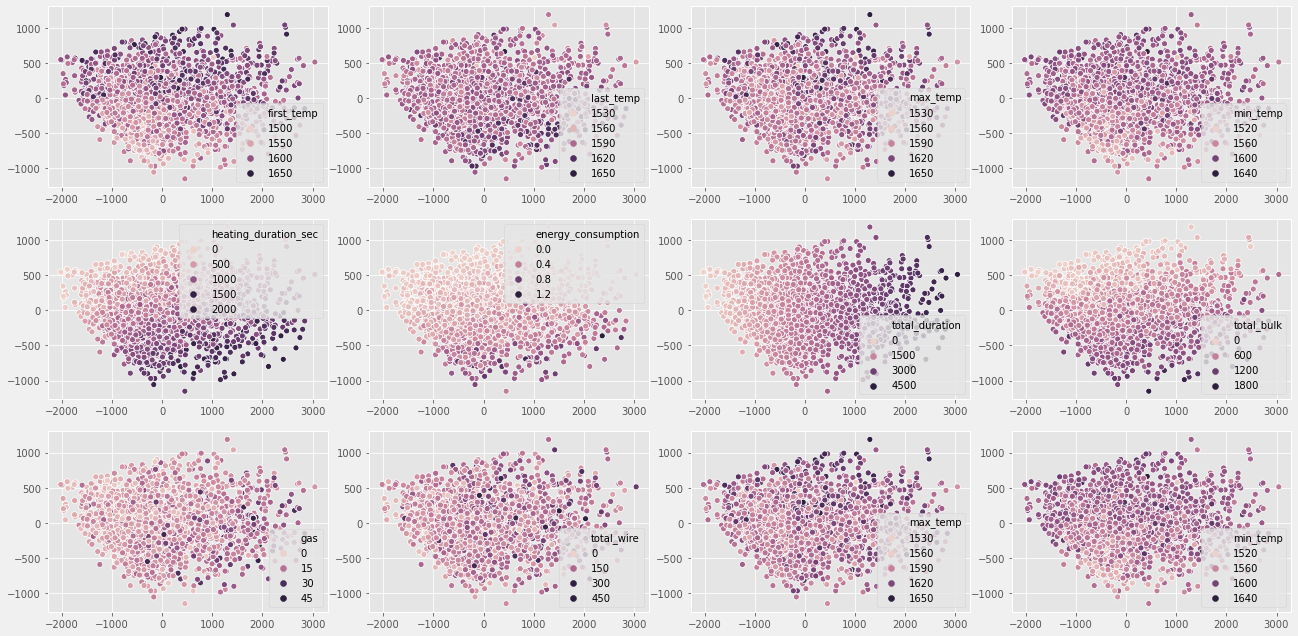

In [400]:
plot_PCA_projection(df, input_features)

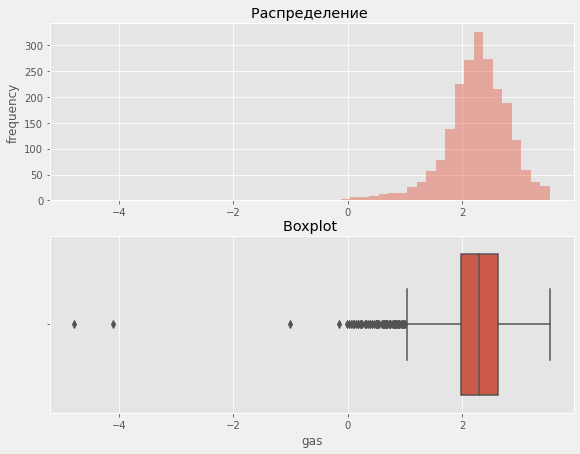

In [401]:
hist_box(np.log(df.gas))

In [402]:
gas_log_outliers_boundary = outliers_boundary(np.log(df.gas), coeff=4)

In [403]:
df = df.loc[np.log(df.gas) > gas_log_outliers_boundary[0]]

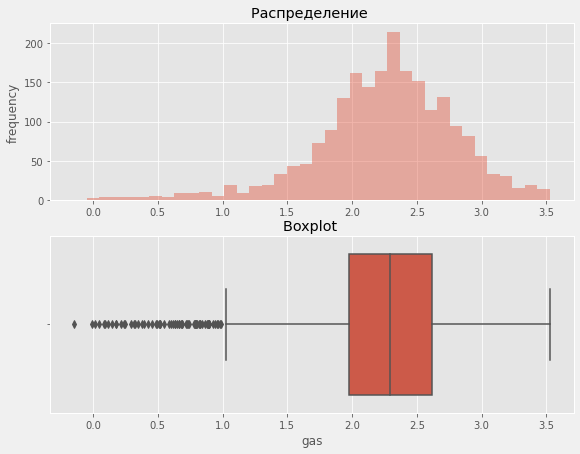

In [404]:
hist_box(np.log(df.gas))

[к Содержанию](#section0)

## Вывод<a id='section3.2.c'></a>

1. На данном шаге произвели анализ данных, выделили таргетное значение, замечено, что для 740 партий имеется только первый замер температуры, отстальные замеры во время итераций отсутствовали. Т.к. в данных партиях невозможно выделить таргет, то их удалили из выборки
2. При анализе воспользовались методом PCA и tNSE для проекции пространства на 2D плоскость. Было замечено, что выбросы по продолжительности изготовления партии сильно влияет на распределение объектров по группа. Всвязи с этим аномальные значения по продолжительности изготовления партии были удалены
3. Также были удалены аномалии в признаках gas, first_temp, last_temp, heating_duratuon, total_wire

# 4. Генерация и Селекция признаков<a id='section4.0'></a>

## Сгенерируем и отберем признаки

Т.к технологические процессы иногда описываются измеряемыми параметрами при их нелинейной зависимости, то на основании этопо добавить признаки, к примеру температуру во 2,3,4 -ой степенях, обратные значения, произведение температуры на количество добавляемого материала, газа и т.п.

Отберем признаки из существующей выборки

In [405]:
X = df.drop(labels=['last_temp', 'max_temp', 'min_temp', 'std_temp'], axis=1)
y = df.last_temp

In [406]:
X = reduce_memory(X)

Initial df memory usage is 0.59 MB for 35 columns
Final memory usage is: 0.16 MB - decreased by 72.9%


Добавим обратное значение к значению температуры

In [407]:
X['temp_converse'] = 1 / X.first_temp

Добавим произведение потраченой энергии на массу добавленных метериалов и вычев значение температуры из логики формулы Q = mc(t2-t1) домножим энергию на 10000, чтобы небыло отрицательных значений и на 3,6 (перевод из MWh в GJ)

In [408]:
X['Q_div_m'] = X.energy_consumption * 3.6 * 10000 / (X.total_bulk / 1000 + X.total_wire / 1000 + 100) + X.first_temp

Отберем признаки

In [409]:
feat_imp_model = RandomForestRegressor(n_estimators=100, random_state=13559)

In [410]:
X_train_fi, X_valid_fi, y_train_fi, y_valid_fi = train_test_split(X, y, test_size=0.25, random_state=13559)

In [411]:
imp_feats_list, df_imp_feat_result = cols_feat_importances(feat_imp_model, X_train_fi, y_train_fi)


Лучший результат при 20 признаках, MAE = 5.56150


In [412]:
del X_train_fi, X_valid_fi, y_train_fi, y_valid_fi

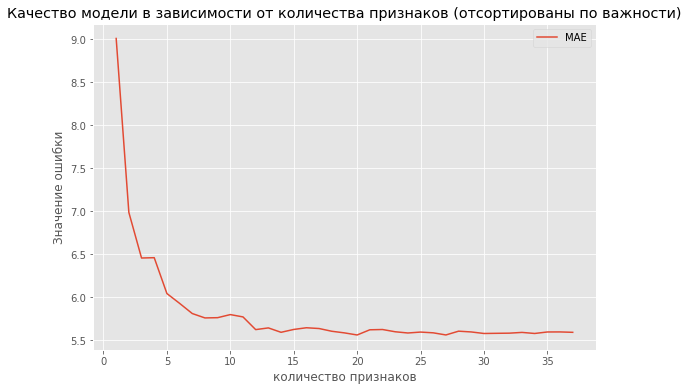

In [413]:
df_imp_feat_result.plot(grid=True, figsize=(9,6))
plt.xlabel('количество признаков')
plt.ylabel('Значение ошибки')
plt.title('Качество модели в зависимости от количества признаков (отсортированы по важности)')

plt.show()

In [414]:
X = X[imp_feats_list]

## Вывод

1. На данном шаге сгенерировали признаки (при генерации проверяли на качестве линейной модели)
2. Наибольший эффект на качество модели из новых признаов оказали - обратное значение температуры и отношение затраченой мощности к общей массе
3. Произвели отбор признаков по их важности с определением качества модели при каждом шаге сокрачения размерности обучающей выборки


[к Содержанию](#section0)

## 5. Модель<a id='section5'></a>

## 5.1. Подготовим выборки<a id='section5.1'></a>

Подготовим выборки, разделим на обучающую, валидационную и тестовую. Для моделей которые будем обучать на кросс валидации соединим обучающую и валидационную

In [415]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=13559)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=13559)

X_train_cv = pd.concat([X_train, X_valid])
y_train_cv = pd.concat([y_train, y_valid])

In [416]:
X_train.shape, X_valid.shape, X_test.shape, X_train_cv.shape

((1604, 20), (267, 20), (268, 20), (1871, 20))

In [417]:
result_table = {
    'model':[],
    'train_score': [],
    'test_score' : []
               }

In [418]:
def add_to_result_table(data, model_name, test_score, train_score):
    data["model"].append(model_name)
    data["train_score"].append(train_score)
    data["test_score"].append(test_score)
    
    df = pd.DataFrame(data)
    
    return df

## 5.2. Линейная регрессия<a id='section5.2'></a>

In [419]:
model_linger = LinearRegression(normalize=True)

model_linger.fit(X_train_cv, y_train_cv)

linger_pred = model_linger.predict(X_test)
linger_train_score = mean_absolute_error(y_train_cv, model_linger.predict(X_train_cv))
linger_MAE = mean_absolute_error(y_test, linger_pred)

In [420]:
add_to_result_table(result_table, 'LinearRegression', linger_MAE, linger_train_score)

model  train_score  test_score
0  LinearRegression        5.330       4.701

## 5.3. LightGBM<a id='section5.3'></a>

In [421]:
RANDOM_SEED = 13559
NUM_FOLDS = 10
EARLY_STOPPING = 50

LIGHTGBM_PARAMS = {
    'subsample_for_bin': 121644,
    'reg_lambda': 3.158578947368421,
    'reg_alpha': 9.473736842105263,
    'num_leaves': 70,
    'n_estimators': 550,
    'min_data_in_leaf': 10,
    'min_child_samples': 28,
    'max_depth': 2,
    'learning_rate': 0.046415888336127774,
    'early_stopping_rounds': 0,
    'colsample_bytree': 1.0,
    'boosting_type': 'goss',
    'verbose' : -1,
}

Проверим дефолтное качество модели

In [422]:
train_set = lgb.Dataset(X_train_cv, label=y_train_cv, free_raw_data=False)

In [423]:
lgb_cv = lgb.cv({'random_state':RANDOM_SEED, 'verbose' : -1}, train_set,
       num_boost_round=LIGHTGBM_PARAMS['n_estimators'], nfold=NUM_FOLDS, early_stopping_rounds=EARLY_STOPPING,
       metrics='mae', seed=RANDOM_SEED, 
      )

In [424]:
np.min(lgb_cv['l1-mean'])

5.530043943385452

Произведем оптимизацию параметров

```python
%%time
lgb_reg = lgb.LGBMRegressor(**{'random_state':RANDOM_SEED})


random_space = {
    'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
    'learning_rate' : list(np.geomspace(0.01, 1, num=10)),
    'num_leaves' : list(range(20, 201, 10)),
    'subsample_for_bin' : list(np.geomspace(20000, 300000, num=10, dtype=int)),
    'min_child_samples' : list(np.geomspace(20, 500, num=10, dtype=int)),
    'reg_alpha' : list(np.linspace(0.001, 10, num=20)),
    'reg_lambda' : list(np.linspace(0.001, 10, num=20)),
    'colsample_bytree' : list(np.linspace(0.6, 1.0, num=5)),
    'min_data_in_leaf' : list(np.geomspace(10, 500, num=5, dtype=int)),
    'max_depth' : [-1, 1, 2, 4, 10],
    'n_estimators': range(50, 700, 50),
    'early_stopping_rounds': [0, EARLY_STOPPING]
}

gs_rand = RandomizedSearchCV(estimator=lgb_reg, param_distributions=random_space, cv=3, n_iter=1000,
                             scoring='neg_mean_absolute_error')


gs_rand.fit(X_train_cv, y_train_cv)

gs_rand.best_params_
OUT: {'subsample_for_bin': 121644,
     'reg_lambda': 3.158578947368421,
     'reg_alpha': 9.473736842105263,
     'num_leaves': 70,
     'n_estimators': 550,
     'min_data_in_leaf': 10,
     'min_child_samples': 28,
     'max_depth': 2,
     'learning_rate': 0.046415888336127774,
     'early_stopping_rounds': 0,
     'colsample_bytree': 1.0,
     'boosting_type': 'goss'}
```

In [425]:
model_lgb = lgb.LGBMRegressor(**LIGHTGBM_PARAMS)
model_lgb.fit(X_train_cv, y_train_cv)

lgb_pred = model_lgb.predict(X_test)
lgb_MAE = mean_absolute_error(y_test, lgb_pred)
lgb_train_MAE = mean_absolute_error(y_train_cv, model_lgb.predict(X_train_cv))

In [426]:
add_to_result_table(result_table, 'LightGBM', lgb_MAE, lgb_train_MAE)

model  train_score  test_score
0  LinearRegression        5.330       4.701
1          LightGBM        4.448       4.691

Воспользуемся API Библиотеки

In [427]:
lgb_train = lgb.Dataset(X_train, y_train, params=LIGHTGBM_PARAMS, free_raw_data=False)
lgb_eval  = lgb.Dataset(X_valid, y_valid, params=LIGHTGBM_PARAMS, free_raw_data=False)
init_gbm  = lgb.train(LIGHTGBM_PARAMS, lgb_eval)
gbm = lgb.train(LIGHTGBM_PARAMS, lgb_train,
                valid_sets=lgb_eval,
                verbose_eval=False,
                init_model=init_gbm)

[LightGBM] [Warning] early_stopping_round is set=0, early_stopping_rounds=0 will be ignored. Current value: early_stopping_round=0
[LightGBM] [Warning] num_iterations is set=550, n_estimators=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=10


In [428]:
lgb_pred_api = gbm.predict(X_test)
lgb_MAE_api = mean_absolute_error(y_test, lgb_pred_api)
lgb_train_MAE_api = mean_absolute_error(y_train, gbm.predict(X_train))

In [429]:
add_to_result_table(result_table, 'LightGBM.train', lgb_MAE_api, lgb_train_MAE_api)

model  train_score  test_score
0  LinearRegression        5.330       4.701
1          LightGBM        4.448       4.691
2    LightGBM.train        4.572       4.754

[к Содержанию](#section0)

## 5.4. Neural Network<a id='section5.4'></a>

In [430]:
SEED = 13559
def set_seed(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [431]:
input_shape = [X_train.shape[1]]

Minimum Validation Loss: 4.1027


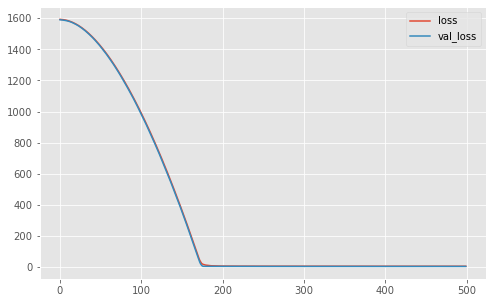

In [432]:
model_net = keras.Sequential([
    
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(40, activation='sigmoid', input_shape=input_shape),
    
    layers.Dropout(0.5),
    
    layers.BatchNormalization(),
    layers.Dense(1),
])


model_net.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 500
history = model_net.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=64,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Minimum Validation Loss: 4.1027


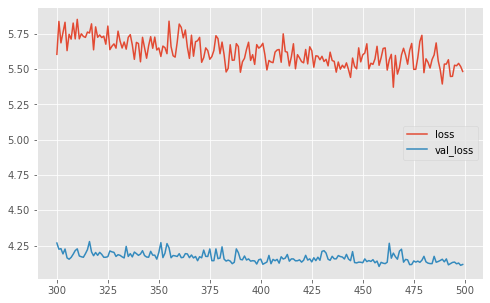

In [433]:
history_df.loc[300:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [434]:
model_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 40)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 40)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 1,121
Trainable params: 1,001
Non-trainable params: 120
_________________________________________________________________


In [435]:
nn_pred = model_net.predict(X_test)
nn_MAE = mean_absolute_error(y_test, nn_pred)
nn_train_MAE = history_df.val_mae.min()

In [436]:
add_to_result_table(result_table, 'NNetwork', nn_MAE, nn_train_MAE)

model  train_score  test_score
0  LinearRegression        5.330       4.701
1          LightGBM        4.448       4.691
2    LightGBM.train        4.572       4.754
3          NNetwork        4.103       4.598

[к Содержанию](#section0)

Проверим модели на вменяемость

In [437]:
sanity_check(y_target=y_test, y_train=y_train)

6.7127842706666145

Посмотрим как модели ошибаются на тестовой выборке

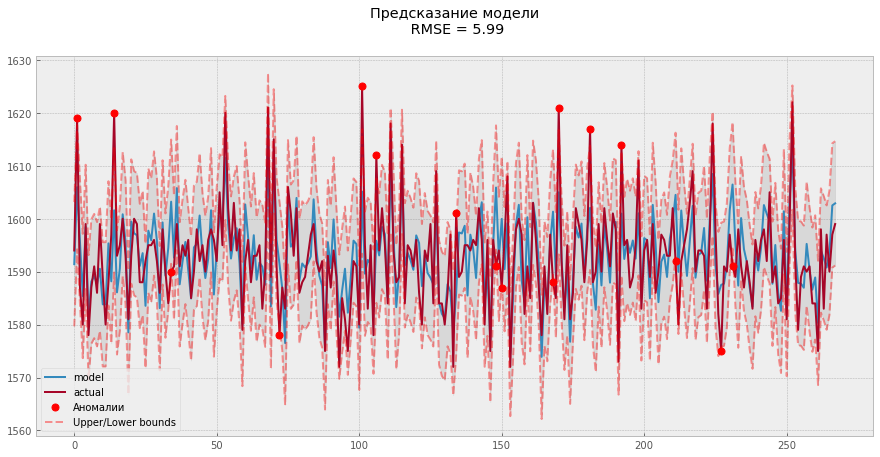

In [438]:
plot_prediction_result(model=model_linger, X_test=X_test, y_test=y_test,
                       plot_inervals=True, plot_anomalies=True, interval_of_interest=300)

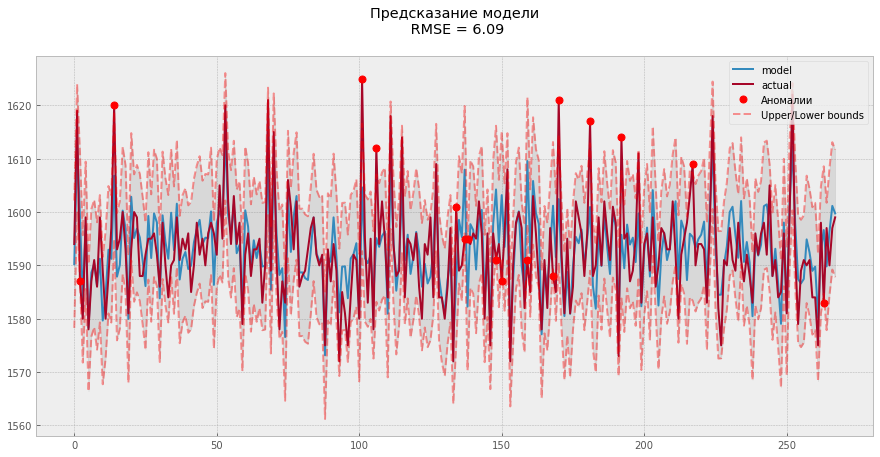

In [439]:
plot_prediction_result(model=model_lgb, X_test=X_test, y_test=y_test,
                       plot_inervals=True, plot_anomalies=True, interval_of_interest=300)

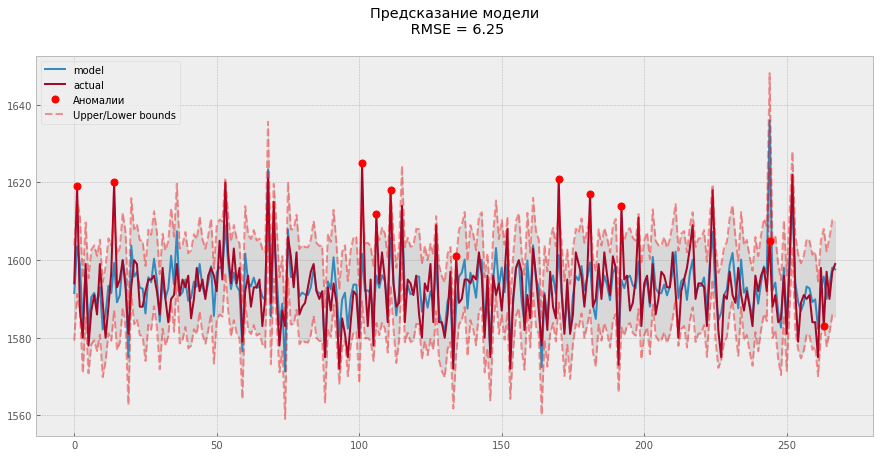

In [440]:
plot_prediction_result(model=model_net, X_test=X_test, y_test=y_test,
                       plot_inervals=True, plot_anomalies=True, interval_of_interest=300)

Как видно, модель построенная на нейронной сети ошибается в отличии от других моделей, приимущественно на аномально высоких пиках графика актыальных значений, в то время, как модель линейной регрессии и бустинга ошибаются при среднем уровне температур 

## Вывод 

1. Все полученные модели отвечают требуему достижению качества
2. Наиболее высокое качество показала модель построенная на архитектуре нейронной сети
3. Модель на архитектуре нейронной в отличии от остальных моделей преимущественно ошибается при аномально высоких уровнях температур в тестовой выборке, в то время, как модель линейной регрессии и бустинга ошибаются при среднем уровне температур
4. Т.к. архитектура сети не глубокая и не требует, серьезных вычислительных затрат, то предлагается использовать ее

[к Содержанию](#section0)